In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline

In [2]:
from classification_model.processing.data_management import load_dataset

In [3]:
train_orig = load_dataset(file_name='AWID-CLS-R-Trn.csv')
test_orig = load_dataset(file_name='AWID-CLS-R-Tst.csv')

In [4]:
from classification_model.processing.data_management import get_target
train_orig, y_train = get_target(train_orig)
test_orig, y_test = get_target(test_orig)

In [5]:
from classification_model.processing.feat_eng_categ import discrete_to_categ, one_hot_encoder, categ_missing_encoder, rare_label_encoder, label_encoder
from classification_model.processing.feat_eng_num import outlier_capping, ArbitraryNumberImputer
from classification_model.processing.feat_creation import feature_creation
from classification_model.processing.feat_selection import remove_constant, remove_quasi_constant, remove_duplicates, selected_drop_features, remove_correlated_features
from sklearn.preprocessing import StandardScaler

In [6]:
from classification_model.config import config

eda_pipe = Pipeline([
                ('cme1', categ_missing_encoder(config.ID_FEATURES)),
                ('fc', feature_creation()),
                ('oc', outlier_capping(distribution='quantiles')),
                ('cme2', categ_missing_encoder()),
                ('rle', rare_label_encoder(0.0001)),                
                ('ani', ArbitraryNumberImputer()),
                ('le', label_encoder()),
                ('sd', selected_drop_features()),
                ('rc', remove_constant()),
                ('rqc', remove_quasi_constant()),
                ('rcf', remove_correlated_features()), 
               ])

eda_final_pipe = Pipeline([
                ('cme1', categ_missing_encoder(config.ID_FEATURES)),
                ('fc', feature_creation()),
                ('oc', outlier_capping(distribution='quantiles')),
                ('cme2', categ_missing_encoder()),
                ('rle', rare_label_encoder(0.0001)),                
                ('ani', ArbitraryNumberImputer()),
                ])

In [7]:
train_prep = eda_pipe.fit_transform(train_orig)
test_prep = eda_pipe.transform(test_orig)

In [8]:
for col in train_prep.columns:
    print(col)

frame.time_delta
frame.time_relative
frame.len
radiotap.flags.cfp
radiotap.datarate
wlan.fc.type_subtype
wlan.fc.type
wlan.fc.subtype
wlan.fc.retry
wlan.duration
wlan.sa
wlan.bssid
wlan.frag
wlan.seq
wlan.bar.type
wlan.ba.control.ackpolicy
wlan_mgt.fixed.capabilities.ess
wlan_mgt.fixed.listen_ival
wlan_mgt.fixed.current_ap
wlan_mgt.fixed.status_code
wlan_mgt.fixed.aid
wlan_mgt.fixed.reason_code
wlan_mgt.fixed.auth.alg
wlan_mgt.fixed.category_code
wlan_mgt.ssid
wlan_mgt.country_info.environment
wlan_mgt.rsn.version
wlan_mgt.tcprep.trsmt_pow
wlan.tkip.extiv
wlan.ccmp.extiv
wlan.qos.bit4
wlan.wep.iv_passed1second_count
wlan.ta_passed1second_count
wlan.wep.iv_passed1second_count_change
wlan.ta_passed1second_count_change
wlan.ra_passed1second_count_change


In [9]:
eda_pipe.steps

[('cme1',
  categ_missing_encoder(features=['wlan.wep.iv', 'wlan.wep.icv', 'wlan.ta',
                                  'wlan.ra', 'wlan.ra', 'wlan.da'])),
 ('fc', feature_creation(features=[None])),
 ('oc',
  outlier_capping(distribution='quantiles',
                  features=['frame.interface_id', 'frame.dlt',
                            'frame.offset_shift', 'frame.time_delta',
                            'frame.time_delta_displayed', 'frame.time_relative',
                            'frame.len', 'frame.cap_len', 'frame.marked',
                            'frame.ignored', 'radiotap.version', 'radiotap.pad',
                            'radiotap.length', 'radiotap.present.tsft',
                            'radiotap.present.flags', 'radiotap.prese...
                            'radiotap.present.dbm_antnoise',
                            'radiotap.present.lock_quality',
                            'radiotap.present.tx_attenuation',
                            'radiotap.present.db_

In [10]:
columns_to_drop = [col for col in train_orig if col not in train_prep]
train = eda_final_pipe.fit_transform(train_orig)
test = eda_final_pipe.transform(test_orig)

train.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns_to_drop, axis=1, inplace = True)

In [11]:
columns_to_drop

['frame.interface_id',
 'frame.dlt',
 'frame.offset_shift',
 'frame.time_epoch',
 'frame.time_delta_displayed',
 'frame.cap_len',
 'frame.marked',
 'frame.ignored',
 'radiotap.version',
 'radiotap.pad',
 'radiotap.length',
 'radiotap.present.tsft',
 'radiotap.present.flags',
 'radiotap.present.rate',
 'radiotap.present.channel',
 'radiotap.present.fhss',
 'radiotap.present.dbm_antsignal',
 'radiotap.present.dbm_antnoise',
 'radiotap.present.lock_quality',
 'radiotap.present.tx_attenuation',
 'radiotap.present.db_tx_attenuation',
 'radiotap.present.dbm_tx_power',
 'radiotap.present.antenna',
 'radiotap.present.db_antsignal',
 'radiotap.present.db_antnoise',
 'radiotap.present.rxflags',
 'radiotap.present.xchannel',
 'radiotap.present.mcs',
 'radiotap.present.ampdu',
 'radiotap.present.vht',
 'radiotap.present.reserved',
 'radiotap.present.rtap_ns',
 'radiotap.present.vendor_ns',
 'radiotap.present.ext',
 'radiotap.mactime',
 'radiotap.flags.preamble',
 'radiotap.flags.wep',
 'radiotap.f

In [12]:
train['class'] = y_train
test['class'] = y_test

train['frame.time_epoch'] = train_orig['frame.time_epoch']
test['frame.time_epoch'] = test_orig['frame.time_epoch']

In [13]:
print( len(train), len(test))

1795574 575642


In [14]:
for col in train.columns:
    print(col)

frame.time_delta
frame.time_relative
frame.len
radiotap.flags.cfp
radiotap.datarate
wlan.fc.type_subtype
wlan.fc.type
wlan.fc.subtype
wlan.fc.retry
wlan.duration
wlan.sa
wlan.bssid
wlan.frag
wlan.seq
wlan.bar.type
wlan.ba.control.ackpolicy
wlan_mgt.fixed.capabilities.ess
wlan_mgt.fixed.listen_ival
wlan_mgt.fixed.current_ap
wlan_mgt.fixed.status_code
wlan_mgt.fixed.aid
wlan_mgt.fixed.reason_code
wlan_mgt.fixed.auth.alg
wlan_mgt.fixed.category_code
wlan_mgt.ssid
wlan_mgt.country_info.environment
wlan_mgt.rsn.version
wlan_mgt.tcprep.trsmt_pow
wlan.tkip.extiv
wlan.ccmp.extiv
wlan.qos.bit4
passed1second
wlan.wep.iv_passed1second_count
wlan.wep.icv_passed1second_count
wlan.ta_passed1second_count
wlan.ra_passed1second_count
wlan.da_passed1second_count
wlan.wep.iv_passed1second_count_change
wlan.wep.icv_passed1second_count_change
wlan.ta_passed1second_count_change
wlan.ra_passed1second_count_change
wlan.da_passed1second_count_change
class
frame.time_epoch


In [15]:
from classification_model.processing.feat_eng_categ import one_hot_encoder
ohe = one_hot_encoder(features='class')
train = ohe.fit_transform(train)
test = ohe.transform(test)

In [16]:
len(train.columns)

47

In [17]:
def h(content):
    display(HTML(content))
    
def timehist(df, tcol, target, col, target_first, clipping=9999999999999999, concat_df = False, odf = None):
    if concat_df == True:
        df = pd.concat([df, odf])
        
    title = target + ' Hist ' + col
    if( target_first==True):
        df[df[target] == 1].set_index(tcol)[col].clip(0, clipping).plot(style='.', figsize=(15, 3))
        df[df[target] == 0].set_index(tcol)[col].clip(0, clipping).plot(style='.', figsize=(15, 3))
        plt.title(title)
        plt.show()
    elif( target_first==False):
        df[df[target] == 0].set_index(tcol)[col].clip(0, clipping).plot(style='.', title= title, figsize=(15, 3))
        df[df[target] == 1].set_index(tcol)[col].clip(0, clipping).plot(style='.', title= title, figsize=(15, 3))
        plt.title(title)
        plt.show()

In [18]:
def _desc(data, col, label):
    d0 = data.describe().reset_index()
    d0.columns = [col, label]
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \

def desc(df_train, col, target, include_test=False, df_test=None):
    d0 = _desc(df_train[col], col, 'Train')
    d1 = _desc(df_train.loc[df_train[target] == 1, col], col, 'Train flooding')
    d2 = _desc(df_train.loc[df_train[target] == 0, col], col, 'Train not flooding')
    if( include_test):
        d3 = _desc(df_test[col], col, 'Test')
        d4 = _desc(df_test.loc[df_test[target] == 1, col], col, 'Test flooding')
        d5 = _desc(df_test.loc[df_test[target] == 0, col], col, 'Test not flooding')
    if( include_test):
        dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5)
    else:
        dd = d0.merge(d1).merge(d2)
    display(dd)
    
    h('<b>Most popular values (NaN = -999):</b>')
    N = 10
    d0 = df_train[[target,col]].groupby(col)[target].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
    d0 = d0.head(N)
    d0 = d0.rename({'size':'Count in train (desc)','mean':'Mean target train','sum':'Sum target train'}, axis=1)
    display(d0)
        
    d1 = df_test[[target,col]].groupby(col)[target].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
    d1 = d1.head(N)
    d1 = d1.rename({'size':'Count in test (desc)','mean':'Mean target test','sum':'Sum target test'}, axis=1)
    display(d1)

In [19]:
def hist1(df,col):
    plt.figure(figsize=(15, 3))
    plt.hist(df[col], bins=70);
    plt.title('Train histogram: ' + col);
    plt.show()

In [20]:
def corr1(df,col):
    N = None #10000
    num_vars = [f for f in df.columns if train[f].dtype != 'object']
    trx = df.head(N) if N is not None else df.copy()
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val)
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))

In [21]:
def numeric(df_input, tcol_input, target_input, col_input, target_first_input, df_test, include_test):
    timehist(df=df_input, tcol=tcol_input, target=target_input, col=col_input, target_first=target_first_input, odf=df_test, concat_df=include_test)
    hist1(df_input,col_input)
    desc(df_input, col_input, target_input, include_test, df_test)
    corr1(df_input,col_input)

In [22]:
def categorical(df, col, target, df_test, include_test):
    desc(df, col, target, include_test, df_test)

In [23]:
def proc(df, tcol, target, col, target_first, df_test, include_test):
    if col not in ['isFraud','TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
        categorical(df, col, target, df_test, include_test) if train[col].dtype == 'object' else numeric(df, tcol, target, col, target_first, df_test, include_test)

In [24]:
columns = list(train.columns)
for x in ['class_normal', 'class_injection', 'class_impersonation', 'class_flooding', 'frame.time_epoch', 'passed1second']:
    print(x)
    columns.remove(x)

class_normal
class_injection
class_impersonation
class_flooding
frame.time_epoch
passed1second


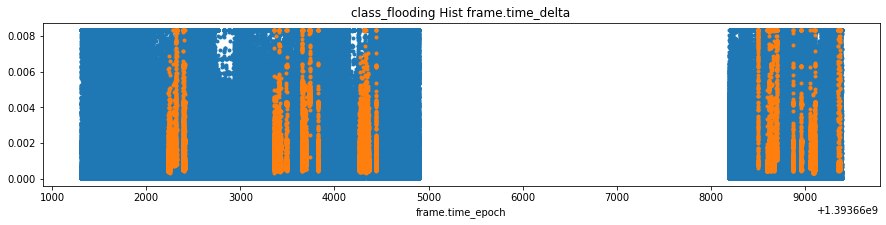

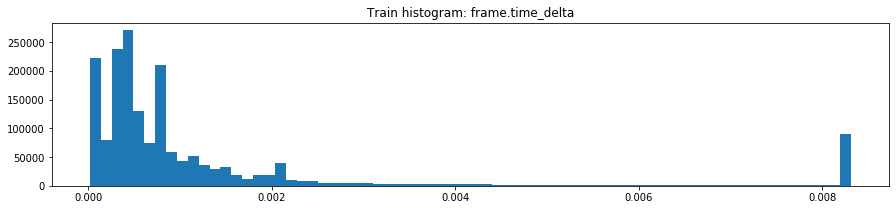

,frame.time_delta,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,1.236585e-03,0.001348,1.233490e-03,0.001291,0.002184,0.001278
2,std,1.926239e-03,0.001235,1.941831e-03,0.002127,0.001965,0.002127
3,min,1.800000e-05,0.000319,1.800000e-05,0.000018,0.000320,0.000018
4,25%,3.150000e-04,0.000687,3.130000e-04,0.000287,0.000790,0.000278
5,50%,5.490000e-04,0.000934,5.250000e-04,0.000499,0.002051,0.000492
6,75%,1.113000e-03,0.001334,1.108000e-03,0.001096,0.002154,0.001073
7,max,8.312000e-03,0.008312,8.312000e-03,0.008312,0.008312,0.008312
8,unique values,8.293000e+03,4005.000000,8.293000e+03,8204.000000,2382.000000,8188.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,frame.time_delta,Count in train (desc),Mean target train,Sum target train
0,0.000018,92022,0.000000,0
1,0.008312,89781,0.004901,440
2,0.000315,13931,0.000000,0
3,0.000312,12071,0.000000,0
4,0.000308,10631,0.000000,0
5,0.000316,8807,0.000000,0
6,0.000311,7798,0.000000,0
7,0.000019,7404,0.000000,0
8,0.000314,7395,0.000000,0
9,0.000313,6978,0.000000,0


,frame.time_delta,Count in test (desc),Mean target test,Sum target test
0,0.000018,59661,0.000000,0
1,0.008312,35404,0.009264,328
2,0.000315,4887,0.000000,0
3,0.000312,4246,0.000000,0
4,0.000308,3469,0.000000,0
5,0.000316,3111,0.000000,0
6,0.000314,2892,0.000000,0
7,0.000311,2670,0.000000,0
8,0.000313,2618,0.000000,0
9,0.000019,2566,0.000000,0


,Column,Correlation with frame.time_delta
0,frame.time_delta,1.000000
1,wlan_mgt.fixed.capabilities.ess,0.564221
2,wlan_mgt.rsn.version,0.425785
3,wlan.frag,0.228032
4,wlan.seq,0.155194
5,class_impersonation,0.086349
29,radiotap.datarate,-0.193314
30,wlan.fc.type,-0.251270
31,wlan.da_passed1second_count,-0.308531
32,wlan.ta_passed1second_count,-0.318203


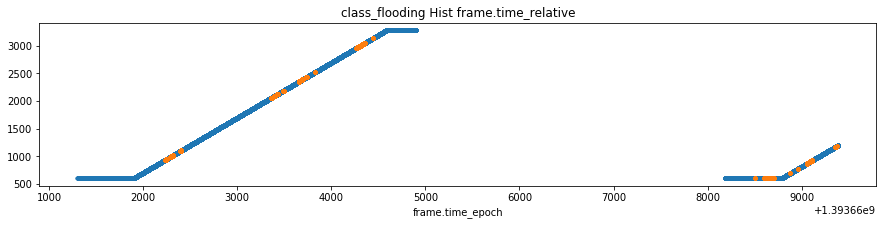

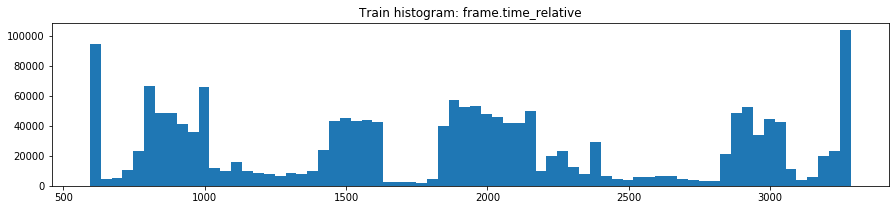

,frame.time_relative,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,1.874668e+03,2385.217154,1.860499e+03,742.167349,732.325939,742.307754
2,std,8.290876e+02,817.502697,8.249131e+02,193.170140,159.236276,193.607735
3,min,5.939958e+02,930.652482,5.939958e+02,593.995827,593.995827,593.995827
4,25%,1.027876e+03,2075.291956,1.012647e+03,593.995827,593.995827,593.995827
5,50%,1.902615e+03,2968.874539,1.895103e+03,593.995827,686.743949,593.995827
6,75%,2.524325e+03,3013.594200,2.397503e+03,930.050902,902.256409,931.581166
7,max,3.285420e+03,3139.027007,3.285420e+03,1200.289872,1183.890811,1200.289872
8,unique values,1.616018e+06,48484.000000,1.567534e+06,269748.000000,4055.000000,265694.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,frame.time_relative,Count in train (desc),Mean target train,Sum target train
0,593.995827,89779,0,0
1,3285.420471,89779,0,0
2,593.999773,1,0,0
3,2125.854397,1,0,0
4,2125.853465,1,0,0
5,2125.853012,1,0,0
6,2125.852550,1,0,0
7,2125.852138,1,0,0
8,2125.851743,1,0,0
9,2125.851326,1,0,0


,frame.time_relative,Count in test (desc),Mean target test,Sum target test
0,593.995827,305895,0.013217,4043
1,969.175157,1,0.000000,0
2,969.176185,1,0.000000,0
3,969.177658,1,0.000000,0
4,969.177971,1,0.000000,0
5,969.178315,1,0.000000,0
6,969.178335,1,0.000000,0
7,969.179229,1,0.000000,0
8,969.180134,1,0.000000,0
9,969.180449,1,0.000000,0


,Column,Correlation with frame.time_relative
0,frame.time_relative,1.000000
1,passed1second,0.996361
2,frame.time_epoch,0.996361
3,wlan.wep.icv_passed1second_count,0.142191
4,wlan.wep.iv_passed1second_count,0.142191
5,class_flooding,0.102584
29,wlan.ta_passed1second_count,-0.191946
30,wlan.ra_passed1second_count,-0.192724
31,frame.len,-0.207853
32,radiotap.datarate,-0.228838


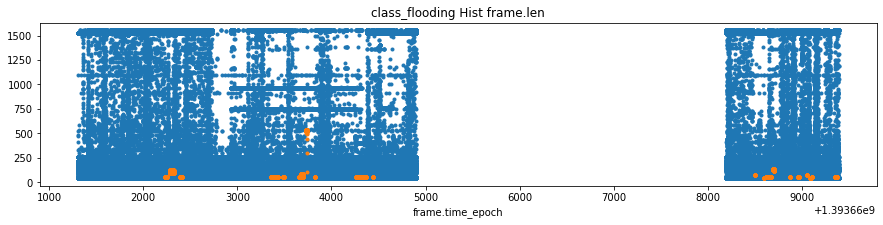

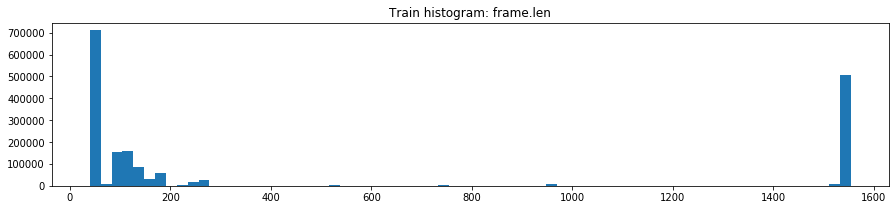

,frame.len,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,5.153132e+02,75.203696,5.275268e+02,519.776592,58.454613,526.358139
2,std,6.649217e+02,83.638935,6.698295e+02,665.988137,21.176814,668.417637
3,min,4.000000e+01,56.000000,4.000000e+01,40.000000,40.000000,40.000000
4,25%,4.000000e+01,56.000000,4.000000e+01,40.000000,54.000000,40.000000
5,50%,1.120000e+02,56.000000,1.240000e+02,124.000000,56.000000,124.000000
6,75%,1.552000e+03,56.000000,1.552000e+03,1552.000000,56.000000,1552.000000
7,max,1.554000e+03,530.000000,1.554000e+03,1554.000000,136.000000,1554.000000
8,unique values,1.332000e+03,45.000000,1.330000e+03,1210.000000,21.000000,1210.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,frame.len,Count in train (desc),Mean target train,Sum target train
0,40.0,452821,0.000000,0
1,1552.0,265889,0.000000,0
2,1554.0,231171,0.000000,0
3,56.0,222708,0.186913,41627
4,98.0,145035,0.000365,53
5,124.0,123930,0.000000,0
6,185.0,38668,0.000000,0
7,128.0,30501,0.000000,0
8,148.0,30409,0.000000,0
9,159.0,27623,0.000000,0


,frame.len,Count in test (desc),Mean target test,Sum target test
0,40.0,185920,0.009461,1759
1,1552.0,98328,0.000000,0
2,1554.0,58576,0.000000,0
3,124.0,39058,0.000691,27
4,98.0,30029,0.000000,0
5,66.0,18606,0.000000,0
6,118.0,17920,0.000000,0
7,185.0,14972,0.000000,0
8,128.0,13217,0.006507,86
9,148.0,10086,0.000000,0


,Column,Correlation with frame.len
0,frame.len,1.000000
1,radiotap.datarate,0.755432
2,wlan.fc.type,0.570831
3,wlan.ta_passed1second_count,0.449671
4,wlan.frag,0.416663
5,wlan.seq,0.361998
29,frame.time_epoch,-0.199610
30,passed1second,-0.199612
31,frame.time_relative,-0.207853
32,wlan.wep.icv_passed1second_count,-0.537759


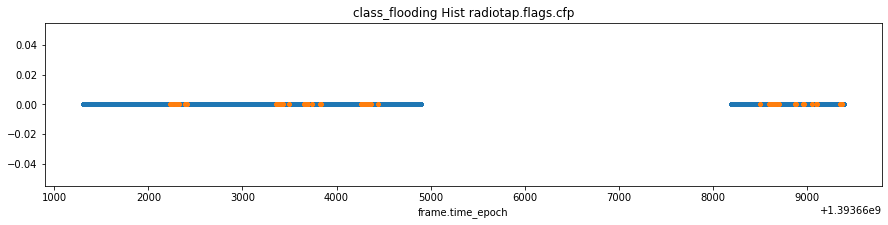

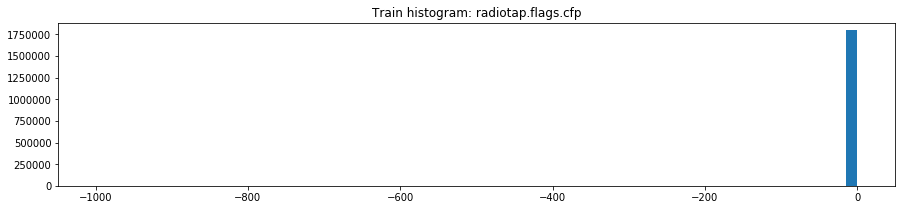

,radiotap.flags.cfp,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.0,1.747090e+06,575642.000000,8097.0,567545.000000
1,mean,-4.339671e-01,0.0,-4.460102e-01,-0.451218,0.0,-0.457655
2,std,2.081694e+01,0.0,2.110369e+01,21.226491,0.0,21.377302
3,min,-9.990000e+02,0.0,-9.990000e+02,-999.000000,0.0,-999.000000
4,25%,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000
5,50%,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000
6,75%,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000
7,max,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000
8,unique values,2.000000e+00,1.0,2.000000e+00,2.000000,1.0,2.000000
9,NaNs,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000


,radiotap.flags.cfp,Count in train (desc),Mean target train,Sum target train
0,0.0,1794794,0.027014,48484
1,-999.0,780,0.000000,0


,radiotap.flags.cfp,Count in test (desc),Mean target test,Sum target test
0,0.0,575382,0.014072,8097
1,-999.0,260,0.000000,0


,Column,Correlation with radiotap.flags.cfp
0,radiotap.flags.cfp,1.000000
1,wlan.fc.type,0.032361
2,wlan.ra_passed1second_count,0.028262
3,wlan.ta_passed1second_count,0.027846
4,wlan.wep.iv_passed1second_count_change,0.027022
5,wlan.wep.icv_passed1second_count_change,0.027021
29,wlan_mgt.tcprep.trsmt_pow,0.000097
30,wlan_mgt.fixed.category_code,0.000082
31,class_normal,-0.006573
32,wlan.frag,-0.012152


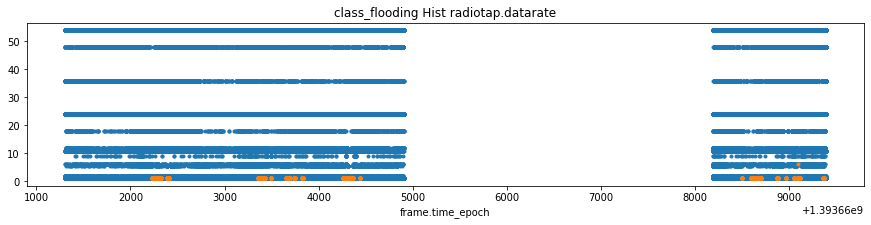

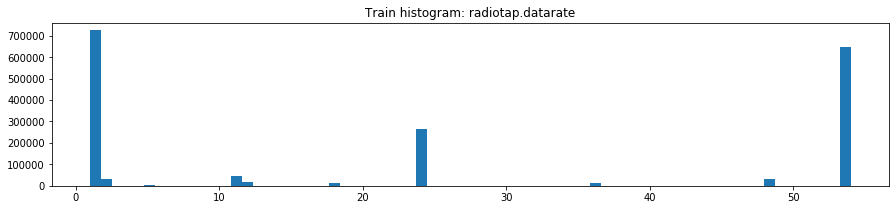

,radiotap.datarate,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.0,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,2.513951e+01,1.0,2.580941e+01,25.369171,1.000618,25.716830
2,std,2.373590e+01,0.0,2.371514e+01,21.570751,0.055566,21.525397
3,min,1.000000e+00,1.0,1.000000e+00,1.000000,1.000000,1.000000
4,25%,1.000000e+00,1.0,1.000000e+00,1.000000,1.000000,1.000000
5,50%,2.400000e+01,1.0,2.400000e+01,24.000000,1.000000,24.000000
6,75%,5.400000e+01,1.0,5.400000e+01,54.000000,1.000000,54.000000
7,max,5.400000e+01,1.0,5.400000e+01,54.000000,6.000000,54.000000
8,unique values,1.200000e+01,1.0,1.200000e+01,12.000000,2.000000,12.000000
9,NaNs,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.000000


,radiotap.datarate,Count in train (desc),Mean target train,Sum target train
0,1.0,724033,0.066964,48484
1,54.0,648415,0.000000,0
2,24.0,266381,0.000000,0
3,11.0,43882,0.000000,0
4,2.0,33956,0.000000,0
5,48.0,30251,0.000000,0
6,12.0,16182,0.000000,0
7,36.0,14859,0.000000,0
8,18.0,14245,0.000000,0
9,5.5,1730,0.000000,0


,radiotap.datarate,Count in test (desc),Mean target test,Sum target test
0,1.0,184682,0.043838,8096
1,54.0,167412,0.000000,0
2,24.0,133667,0.000000,0
3,36.0,18282,0.000000,0
4,11.0,17539,0.000000,0
5,48.0,17217,0.000000,0
6,12.0,16594,0.000000,0
7,18.0,15574,0.000000,0
8,2.0,3630,0.000000,0
9,5.5,473,0.000000,0


,Column,Correlation with radiotap.datarate
0,radiotap.datarate,1.000000
1,frame.len,0.755432
2,wlan.fc.type,0.726434
3,class_normal,0.320680
4,wlan.qos.bit4,0.309145
5,wlan.ta_passed1second_count,0.263270
29,frame.time_relative,-0.228838
30,wlan_mgt.fixed.capabilities.ess,-0.340238
31,wlan.duration,-0.361728
32,wlan.wep.icv_passed1second_count,-0.665311


,wlan.fc.type_subtype,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,17,6,17,17,7,17
2,top,0x28,0x0c,0x28,0x28,0x0c,0x28
3,freq,661349,26002,661349,187804,4682,187804
4,unique values,17,6,17,17,7,17
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan.fc.type_subtype,Count in train (desc),Mean target train,Sum target train
0,0x28,661349,0.000000,0
1,0x1d,416915,0.000000,0
2,0x20,233909,0.000000,0
3,0x0c,206058,0.126188,26002
4,0x08,133015,0.013525,1799
5,0x1c,35906,0.000000,0
6,0x05,19077,0.081669,1558
7,0x24,18564,0.000000,0
8,0x0b,15999,0.022939,367
9,0x0a,15658,0.997892,15625


,wlan.fc.type_subtype,Count in test (desc),Mean target test,Sum target test
0,0x28,187804,0.000000,0
1,0x1d,183656,0.000000,0
2,0x20,126862,0.000000,0
3,0x08,52972,0.011308,599
4,0x05,6937,0.000000,0
5,0x0c,5963,0.785175,4682
6,0x24,5340,0.030899,165
7,0x04,2690,0.137175,369
8,0x1c,2264,0.776943,1759
9,0x0a,326,0.993865,324


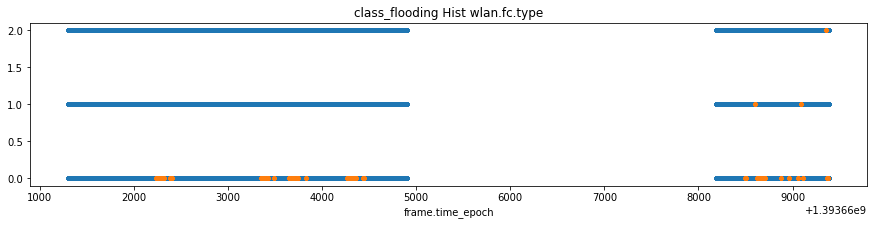

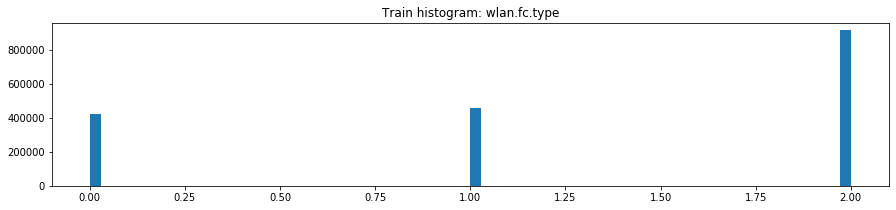

,wlan.fc.type,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.0,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,1.272583e+00,0.0,1.307899e+00,1.435601,0.282574,1.452050
2,std,8.198057e-01,0.0,8.028343e-01,0.697704,0.493469,0.686313
3,min,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.000000
4,25%,1.000000e+00,0.0,1.000000e+00,1.000000,0.000000,1.000000
5,50%,2.000000e+00,0.0,2.000000e+00,2.000000,0.000000,2.000000
6,75%,2.000000e+00,0.0,2.000000e+00,2.000000,1.000000,2.000000
7,max,2.000000e+00,0.0,2.000000e+00,2.000000,2.000000,2.000000
8,unique values,3.000000e+00,1.0,3.000000e+00,3.000000,3.000000,3.000000
9,NaNs,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.000000


,wlan.fc.type,Count in train (desc),Mean target train,Sum target train
0,2.0,914814,0.000000,0
1,1.0,455389,0.000000,0
2,0.0,425371,0.113981,48484


,wlan.fc.type,Count in test (desc),Mean target test,Sum target test
0,2.0,320097,0.000515,165
1,1.0,186198,0.010516,1958
2,0.0,69347,0.086146,5974


,Column,Correlation with wlan.fc.type
0,wlan.fc.type,1.000000
1,radiotap.datarate,0.726434
2,frame.len,0.570831
3,wlan.qos.bit4,0.264604
4,wlan.frag,0.193819
5,wlan.da_passed1second_count,0.184005
29,wlan.duration,-0.372593
30,wlan.fc.subtype,-0.454027
31,wlan_mgt.fixed.capabilities.ess,-0.519339
32,wlan.wep.iv_passed1second_count,-0.664378


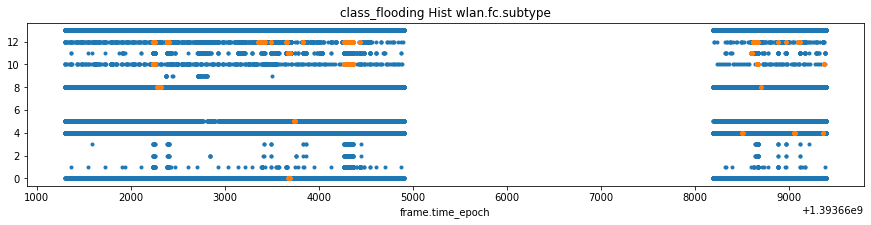

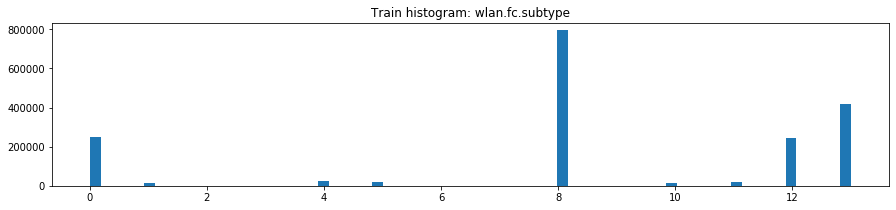

,wlan.fc.subtype,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,8.499055e+00,10.199097,8.451877e+00,7.800107,11.071878,7.753429
2,std,4.173016e+00,3.086589,4.189334e+00,4.756858,2.174461,4.767407
3,min,0.000000e+00,0.000000,0.000000e+00,0.000000,4.000000,0.000000
4,25%,8.000000e+00,10.000000,8.000000e+00,8.000000,12.000000,8.000000
5,50%,8.000000e+00,12.000000,8.000000e+00,8.000000,12.000000,8.000000
6,75%,1.200000e+01,12.000000,1.200000e+01,13.000000,12.000000,13.000000
7,max,1.300000e+01,12.000000,1.300000e+01,13.000000,12.000000,13.000000
8,unique values,1.200000e+01,6.000000,1.200000e+01,11.000000,5.000000,11.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.fc.subtype,Count in train (desc),Mean target train,Sum target train
0,8.0,794387,0.002265,1799
1,13.0,416943,0.000000,0
2,0.0,249393,0.012563,3133
3,12.0,242956,0.107023,26002
4,4.0,25443,0.000000,0
5,5.0,19077,0.081669,1558
6,11.0,17274,0.021246,367
7,10.0,16850,0.927300,15625
8,1.0,12973,0.000000,0
9,3.0,109,0.000000,0


,wlan.fc.subtype,Count in test (desc),Mean target test,Sum target test
0,8.0,240776,0.002488,599
1,13.0,183659,0.000000,0
2,0.0,126911,0.000000,0
3,12.0,8318,0.774345,6441
4,4.0,8030,0.066501,534
5,5.0,6937,0.000000,0
6,11.0,504,0.394841,199
7,10.0,393,0.824427,324
8,1.0,60,0.000000,0
9,3.0,31,0.000000,0


,Column,Correlation with wlan.fc.subtype
0,wlan.fc.subtype,1.000000
1,class_normal,0.398813
2,wlan.wep.icv_passed1second_count,0.371169
3,wlan.wep.iv_passed1second_count,0.371164
4,wlan.ra_passed1second_count,0.182388
5,wlan.fc.retry,0.169900
29,class_impersonation,-0.315907
30,class_injection,-0.395906
31,wlan.seq,-0.436513
32,wlan.fc.type,-0.454027


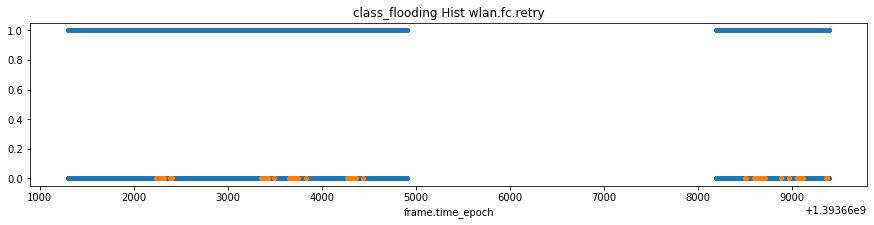

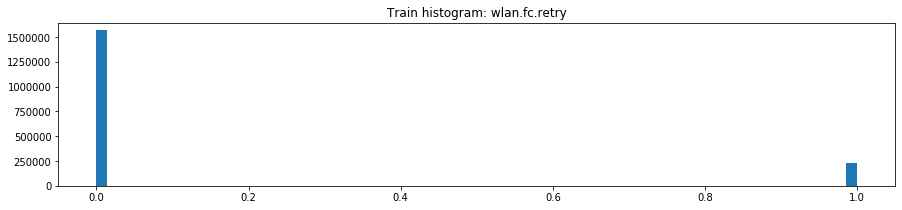

,wlan.fc.retry,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.0,1.747090e+06,575642.000000,8097.0,567545.000000
1,mean,1.271081e-01,0.0,1.306355e-01,0.066616,0.0,0.067566
2,std,3.330941e-01,0.0,3.370014e-01,0.249356,0.0,0.251001
3,min,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000
4,25%,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000
5,50%,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000
6,75%,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000
7,max,1.000000e+00,0.0,1.000000e+00,1.000000,0.0,1.000000
8,unique values,2.000000e+00,1.0,2.000000e+00,2.000000,1.0,2.000000
9,NaNs,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000


,wlan.fc.retry,Count in train (desc),Mean target train,Sum target train
0,0.0,1567342,0.030934,48484
1,1.0,228232,0.000000,0


,wlan.fc.retry,Count in test (desc),Mean target test,Sum target test
0,0.0,537295,0.01507,8097
1,1.0,38347,0.00000,0


,Column,Correlation with wlan.fc.retry
0,wlan.fc.retry,1.000000
1,wlan.duration,0.505578
2,wlan.wep.icv_passed1second_count,0.313395
3,wlan.wep.iv_passed1second_count,0.313394
4,wlan.ta_passed1second_count,0.271912
5,wlan.frag,0.222434
29,frame.time_epoch,-0.095855
30,frame.len,-0.097268
31,frame.time_relative,-0.101519
32,radiotap.datarate,-0.191576


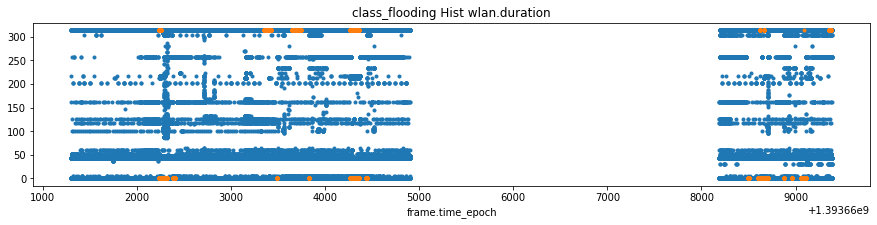

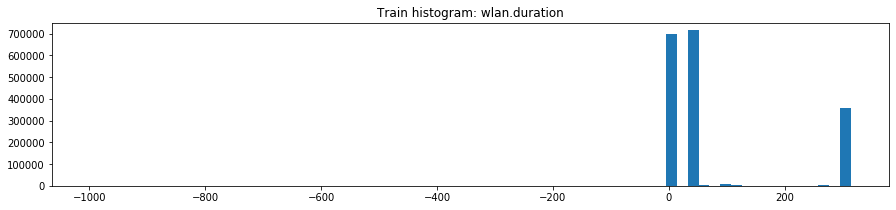

,wlan.duration,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.00000,567545.000000
1,mean,8.098478e+01,171.656010,7.846854e+01,49.636416,60.53526,49.480926
2,std,1.213876e+02,156.316043,1.192951e+02,90.519200,123.87675,89.944438
3,min,-9.990000e+02,0.000000,-9.990000e+02,-999.000000,0.00000,-999.000000
4,25%,0.000000e+00,0.000000,0.000000e+00,0.000000,0.00000,0.000000
5,50%,4.400000e+01,314.000000,4.400000e+01,44.000000,0.00000,44.000000
6,75%,4.400000e+01,314.000000,4.400000e+01,44.000000,0.00000,44.000000
7,max,3.140000e+02,314.000000,3.140000e+02,314.000000,314.00000,314.000000
8,unique values,9.300000e+01,2.000000,9.300000e+01,50.000000,2.00000,50.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.00000,0.000000


,wlan.duration,Count in train (desc),Mean target train,Sum target train
0,44.0,700767,0.000000,0
1,0.0,699624,0.031415,21979
2,314.0,334922,0.079138,26505
3,308.0,21919,0.000000,0
4,48.0,14292,0.000000,0
5,106.0,7382,0.000000,0
6,258.0,3847,0.000000,0
7,124.0,2093,0.000000,0
8,110.0,1879,0.000000,0
9,52.0,1830,0.000000,0


,wlan.duration,Count in test (desc),Mean target test,Sum target test
0,0.0,277211,0.023578,6536
1,44.0,224313,0.000000,0
2,314.0,54597,0.028591,1561
3,48.0,14741,0.000000,0
4,258.0,2077,0.000000,0
5,162.0,559,0.000000,0
6,52.0,524,0.000000,0
7,304.0,394,0.000000,0
8,213.0,206,0.000000,0
9,6.0,146,0.000000,0


,Column,Correlation with wlan.duration
0,wlan.duration,1.000000
1,wlan.fc.retry,0.505578
2,wlan.wep.iv_passed1second_count,0.466967
3,wlan.wep.icv_passed1second_count,0.466961
4,class_injection,0.373148
5,wlan.frag,0.305970
29,wlan_mgt.rsn.version,-0.121914
30,frame.len,-0.197462
31,class_normal,-0.254432
32,radiotap.datarate,-0.361728


,wlan.sa,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,30,14,30,27,14,26
2,top,00:13:33:87:62:6d,b0:48:7a:e2:62:23,00:13:33:87:62:6d,00:13:33:87:62:6d,28:c6:8e:86:d3:d6,00:13:33:87:62:6d
3,freq,573730,13979,573186,187870,4110,187784
4,unique values,30,14,30,27,14,26
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan.sa,Count in train (desc),Mean target train,Sum target train
0,00:13:33:87:62:6d,573730,0.000948,544
1,Missing,455389,0.000000,0
2,28:c6:8e:86:d3:d6,234723,0.038620,9065
3,00:18:41:95:de:dd,137596,0.000000,0
4,c0:18:85:94:b6:55,124391,0.007645,951
5,b0:48:7a:e2:62:23,62341,0.224234,13979
6,00:25:bc:ed:07:cf,41516,0.029699,1233
7,38:22:9d:ae:c5:65,28219,0.010135,286
8,20:64:32:54:c9:da,26372,0.015774,416
9,b0:48:7a:e2:64:af,23260,0.000000,0


,wlan.sa,Count in test (desc),Mean target test,Sum target test
0,00:13:33:87:62:6d,187870,0.000458,86
1,Missing,186198,0.010516,1958
2,00:18:41:95:de:dd,42193,0.000000,0
3,c0:18:85:94:b6:55,33829,0.000591,20
4,Rare,29227,0.022240,650
5,20:64:32:54:c9:da,25685,0.001908,49
6,28:c6:8e:86:d3:d6,19816,0.207408,4110
7,b0:48:7a:e2:62:23,10450,0.002967,31
8,38:22:9d:ae:c5:65,10034,0.005481,55
9,3c:5a:37:8c:9a:41,7479,0.000802,6


,wlan.bssid,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,13,5,13,13,7,13
2,top,28:c6:8e:86:d3:d6,b0:48:7a:e2:62:23,28:c6:8e:86:d3:d6,28:c6:8e:86:d3:d6,28:c6:8e:86:d3:d6,28:c6:8e:86:d3:d6
3,freq,1110899,27868,1095304,269293,4703,264590
4,unique values,13,5,13,13,7,13
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan.bssid,Count in train (desc),Mean target train,Sum target train
0,28:c6:8e:86:d3:d6,1110899,0.014038,15595
1,Missing,454197,0.000000,0
2,b0:48:7a:e2:62:23,103558,0.269105,27868
3,00:13:33:87:62:6d,63359,0.017188,1089
4,38:22:9d:ae:c5:65,30761,0.018693,575
5,38:22:9d:c4:8d:28,16484,0.000000,0
6,ff:ff:ff:ff:ff:ff,6684,0.000000,0
7,fc:0a:81:0f:dc:70,4563,0.000000,0
8,Rare,3837,0.874902,3357
9,00:13:33:1d:5c:62,344,0.000000,0


,wlan.bssid,Count in test (desc),Mean target test,Sum target test
0,28:c6:8e:86:d3:d6,269293,0.017464,4703
1,Missing,186131,0.010519,1958
2,00:13:33:87:62:6d,79414,0.002178,173
3,b0:48:7a:e2:62:23,11903,0.004873,58
4,38:22:9d:ae:c5:65,10669,0.010029,107
5,38:22:9d:c4:8d:28,6988,0.000000,0
6,fc:0a:81:0f:dc:70,3833,0.000000,0
7,ff:ff:ff:ff:ff:ff,2612,0.141271,369
8,Rare,1971,0.369863,729
9,dc:02:8e:7f:39:5e,1536,0.000000,0


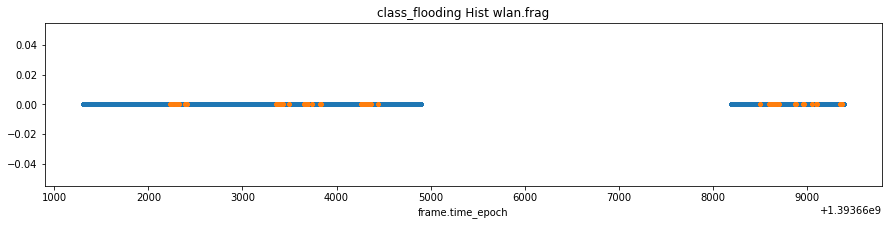

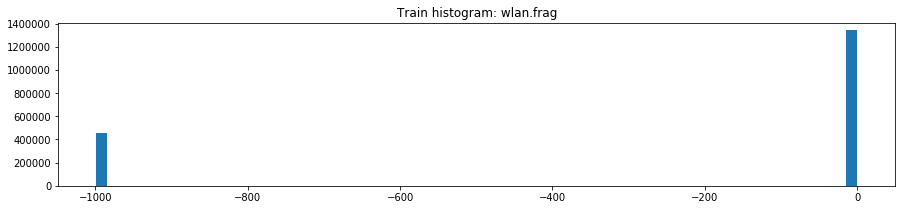

,wlan.frag,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.0,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,-2.533639e+02,0.0,-2.603951e+02,-323.137995,-241.576139,-324.301615
2,std,4.346463e+02,0.0,4.385535e+02,467.329726,427.782810,467.767209
3,min,-9.990000e+02,0.0,-9.990000e+02,-999.000000,-999.000000,-999.000000
4,25%,-9.990000e+02,0.0,-9.990000e+02,-999.000000,0.000000,-999.000000
5,50%,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.000000
6,75%,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.000000
7,max,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.000000
8,unique values,2.000000e+00,1.0,2.000000e+00,2.000000,2.000000,2.000000
9,NaNs,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,0.000000


,wlan.frag,Count in train (desc),Mean target train,Sum target train
0,0.0,1340185,0.036177,48484
1,-999.0,455389,0.000000,0


,wlan.frag,Count in test (desc),Mean target test,Sum target test
0,0.0,389444,0.015763,6139
1,-999.0,186198,0.010516,1958


,Column,Correlation with wlan.frag
0,wlan.frag,1.000000
1,wlan.seq,0.777756
2,frame.len,0.416663
3,wlan.duration,0.305970
4,radiotap.datarate,0.261307
5,frame.time_delta,0.228032
29,wlan.wep.icv_passed1second_count_change,-0.124674
30,class_normal,-0.183808
31,wlan.wep.iv_passed1second_count,-0.316018
32,wlan.wep.icv_passed1second_count,-0.316019


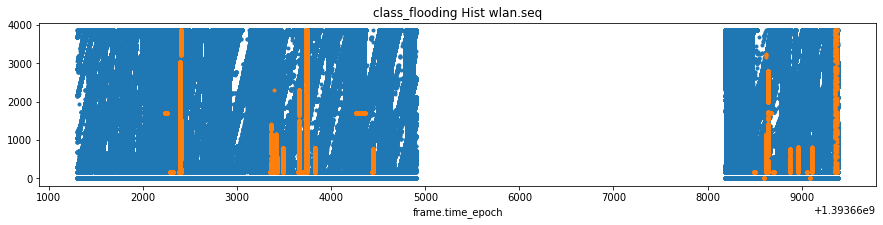

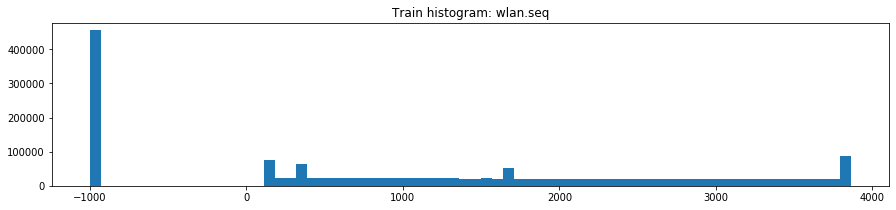

,wlan.seq,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,1.171302e+03,1408.179750,1.164728e+03,935.569710,395.884772,943.269239
2,std,1.626620e+03,710.722701,1.644293e+03,1641.747232,1050.540818,1647.370524
3,min,-9.990000e+02,158.000000,-9.990000e+02,-999.000000,-999.000000,-999.000000
4,25%,-9.990000e+02,994.000000,-9.990000e+02,-999.000000,158.000000,-999.000000
5,50%,1.174000e+03,1703.000000,1.138000e+03,935.000000,281.000000,958.000000
6,75%,2.557000e+03,1703.000000,2.593000e+03,2293.000000,888.000000,2310.000000
7,max,3.862000e+03,3862.000000,3.862000e+03,3862.000000,3862.000000,3862.000000
8,unique values,3.706000e+03,3243.000000,3.706000e+03,3706.000000,2002.000000,3706.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.seq,Count in train (desc),Mean target train,Sum target train
0,-999.0,455389,0.000000,0
1,3862.0,67222,0.003079,207
2,158.0,67023,0.096698,6481
3,1703.0,31511,0.989559,31182
4,345.0,9404,0.000851,8
5,355.0,8988,0.001001,9
6,359.0,8818,0.000907,8
7,364.0,8451,0.001065,9
8,368.0,7927,0.001514,12
9,320.0,414,0.038647,16


,wlan.seq,Count in test (desc),Mean target test,Sum target test
0,-999.0,186198,0.010516,1958
1,1293.0,25583,0.000039,1
2,158.0,22243,0.073147,1627
3,3862.0,17667,0.000679,12
4,1703.0,562,0.848754,477
5,192.0,123,0.040650,5
6,961.0,122,0.008197,1
7,357.0,121,0.041322,5
8,187.0,121,0.041322,5
9,798.0,121,0.033058,4


,Column,Correlation with wlan.seq
0,wlan.seq,1.000000
1,wlan.frag,0.777756
2,frame.len,0.361998
3,wlan.duration,0.256990
4,radiotap.datarate,0.245019
5,wlan.fc.retry,0.197496
29,wlan.wep.iv_passed1second_count_change,-0.101378
30,wlan.wep.icv_passed1second_count_change,-0.101397
31,wlan.wep.iv_passed1second_count,-0.241303
32,wlan.wep.icv_passed1second_count,-0.241304


,wlan.bar.type,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,2,1,2,1,1,1
2,top,Missing,Missing,Missing,Missing,Missing,Missing
3,freq,1795551,48484,1747067,575642,8097,567545
4,unique values,2,1,2,1,1,1
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan.bar.type,Count in train (desc),Mean target train,Sum target train
0,Missing,1795551,0.027002,48484
1,Rare,23,0.000000,0


,wlan.bar.type,Count in test (desc),Mean target test,Sum target test
0,Missing,575642,0.014066,8097


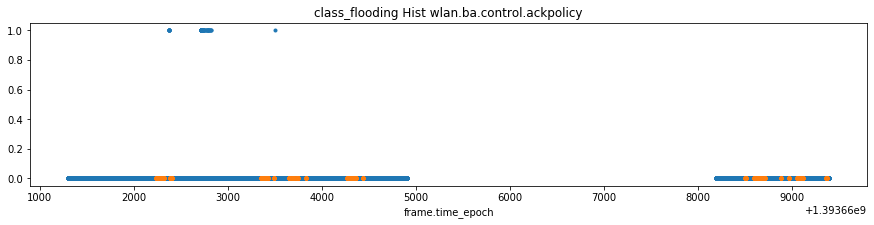

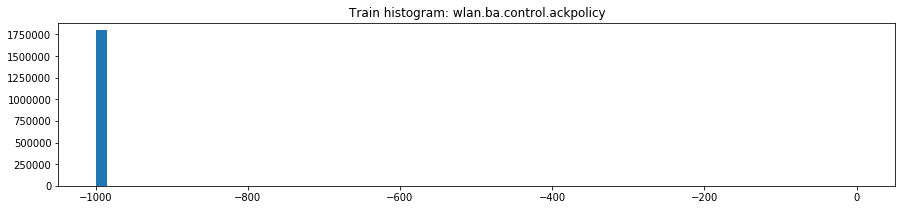

,wlan.ba.control.ackpolicy,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.0,1.747090e+06,575642.0,8097.0,567545.0
1,mean,-9.989438e+02,-999.0,-9.989422e+02,-999.0,-999.0,-999.0
2,std,7.497897e+00,0.0,7.601217e+00,0.0,0.0,0.0
3,min,-9.990000e+02,-999.0,-9.990000e+02,-999.0,-999.0,-999.0
4,25%,-9.990000e+02,-999.0,-9.990000e+02,-999.0,-999.0,-999.0
5,50%,-9.990000e+02,-999.0,-9.990000e+02,-999.0,-999.0,-999.0
6,75%,-9.990000e+02,-999.0,-9.990000e+02,-999.0,-999.0,-999.0
7,max,1.000000e+00,-999.0,1.000000e+00,-999.0,-999.0,-999.0
8,unique values,3.000000e+00,1.0,3.000000e+00,1.0,1.0,1.0
9,NaNs,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0


,wlan.ba.control.ackpolicy,Count in train (desc),Mean target train,Sum target train
0,-999.0,1795473,0.027003,48484
1,1.0,76,0.000000,0
2,0.0,25,0.000000,0


,wlan.ba.control.ackpolicy,Count in test (desc),Mean target test,Sum target test
0,-999.0,575642,0.014066,8097


,Column,Correlation with wlan.ba.control.ackpolicy
0,wlan.ba.control.ackpolicy,1.000000
1,class_normal,0.002365
2,wlan.wep.icv_passed1second_count,0.002327
3,wlan.wep.iv_passed1second_count,0.002327
4,wlan.duration,0.001112
5,wlan.fc.subtype,0.000491
29,wlan.da_passed1second_count,-0.007311
30,wlan.ta_passed1second_count,-0.009679
31,wlan.ra_passed1second_count,-0.009979
32,wlan.seq,-0.010007


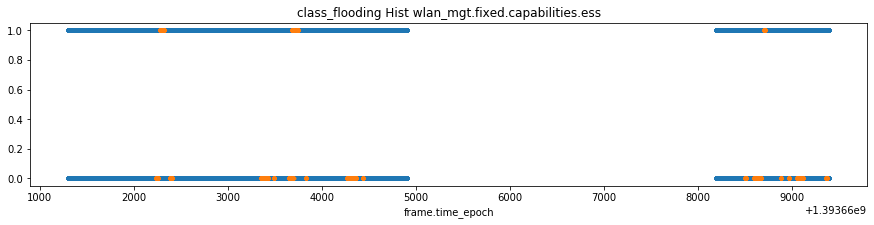

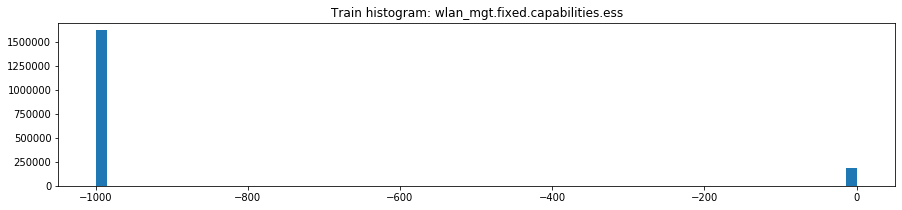

,wlan_mgt.fixed.capabilities.ess,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,-8.983364e+02,-865.141407,-8.992576e+02,-894.643473,-925.021983,-894.210071
2,std,3.008829e+02,340.503834,2.996564e+02,305.722758,261.751277,306.282818
3,min,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.000000,-999.000000
4,25%,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.000000,-999.000000
5,50%,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.000000,-999.000000
6,75%,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.000000,-999.000000
7,max,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000
8,unique values,2.000000e+00,2.000000,2.000000e+00,2.000000,2.000000,2.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan_mgt.fixed.capabilities.ess,Count in train (desc),Mean target train,Sum target train
0,-999.0,1614825,0.026005,41994
1,1.0,180749,0.035906,6490


,wlan_mgt.fixed.capabilities.ess,Count in test (desc),Mean target test,Sum target test
0,-999.0,515570,0.014543,7498
1,1.0,60072,0.009971,599


,Column,Correlation with wlan_mgt.fixed.capabilities.ess
0,wlan_mgt.fixed.capabilities.ess,1.000000
1,wlan_mgt.rsn.version,0.632122
2,frame.time_delta,0.564221
3,wlan.frag,0.195022
4,wlan.seq,0.148193
5,frame.time_relative,0.058760
29,radiotap.datarate,-0.340238
30,wlan.ta_passed1second_count,-0.356189
31,wlan.da_passed1second_count,-0.357361
32,wlan.ra_passed1second_count,-0.376896


,wlan_mgt.fixed.listen_ival,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,4,2,4,4,1,4
2,top,Missing,Missing,Missing,Missing,Missing,Missing
3,freq,1779999,45351,1734648,575570,8097,567473
4,unique values,4,2,4,4,1,4
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan_mgt.fixed.listen_ival,Count in train (desc),Mean target train,Sum target train
0,Missing,1779999,0.025478,45351
1,0x0064,11992,0.000000,0
2,0x000a,3495,0.896423,3133
3,Rare,88,0.000000,0


,wlan_mgt.fixed.listen_ival,Count in test (desc),Mean target test,Sum target test
0,Missing,575570,0.014068,8097
1,0x000a,41,0.000000,0
2,Rare,25,0.000000,0
3,0x0064,6,0.000000,0


,wlan_mgt.fixed.current_ap,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,2,1,2,2,1,2
2,top,Missing,Missing,Missing,Missing,Missing,Missing
3,freq,1795483,48484,1746999,575619,8097,567522
4,unique values,2,1,2,2,1,2
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan_mgt.fixed.current_ap,Count in train (desc),Mean target train,Sum target train
0,Missing,1795483,0.027003,48484
1,Rare,91,0.000000,0


,wlan_mgt.fixed.current_ap,Count in test (desc),Mean target test,Sum target test
0,Missing,575619,0.014067,8097
1,Rare,23,0.000000,0


,wlan_mgt.fixed.status_code,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,4,2,4,4,1,4
2,top,Missing,Missing,Missing,Missing,Missing,Missing
3,freq,1766623,48117,1718506,575296,8097,567199
4,unique values,4,2,4,4,1,4
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan_mgt.fixed.status_code,Count in train (desc),Mean target train,Sum target train
0,Missing,1766623,0.027237,48117
1,0x0000,26543,0.013827,367
2,0x000d,2403,0.000000,0
3,Rare,5,0.000000,0


,wlan_mgt.fixed.status_code,Count in test (desc),Mean target test,Sum target test
0,Missing,575296,0.014074,8097
1,0x0000,332,0.000000,0
2,0x000d,13,0.000000,0
3,Rare,1,0.000000,0


,wlan_mgt.fixed.aid,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,3,1,3,3,1,3
2,top,Missing,Missing,Missing,Missing,Missing,Missing
3,freq,1782492,48484,1734008,575551,8097,567454
4,unique values,3,1,3,3,1,3
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan_mgt.fixed.aid,Count in train (desc),Mean target train,Sum target train
0,Missing,1782492,0.0272,48484
1,0x0001,12981,0.0000,0
2,Rare,101,0.0000,0


,wlan_mgt.fixed.aid,Count in test (desc),Mean target test,Sum target test
0,Missing,575551,0.014068,8097
1,0x0001,59,0.000000,0
2,Rare,32,0.000000,0


,wlan_mgt.fixed.reason_code,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,5,4,5,5,4,5
2,top,Missing,0x0001,Missing,Missing,0x0007,Missing
3,freq,1573839,31180,1567001,569353,4445,566262
4,unique values,5,4,5,5,4,5
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan_mgt.fixed.reason_code,Count in train (desc),Mean target train,Sum target train
0,Missing,1573839,0.004345,6838
1,0x0007,172849,0.060440,10447
2,0x0001,31235,0.998239,31180
3,0x0006,17547,0.000000,0
4,Rare,104,0.182692,19


,wlan_mgt.fixed.reason_code,Count in test (desc),Mean target test,Sum target test
0,Missing,569353,0.005429,3091
1,0x0007,5668,0.784227,4445
2,0x0001,481,0.991684,477
3,Rare,101,0.831683,84
4,0x0006,39,0.000000,0


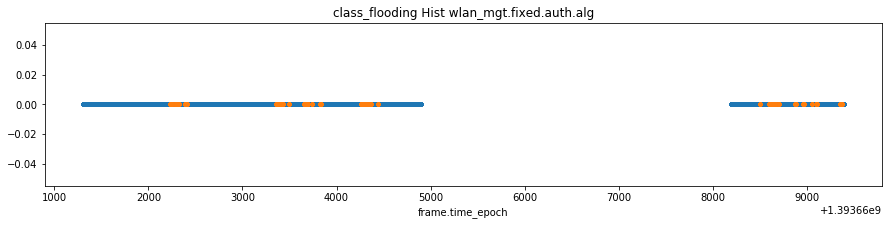

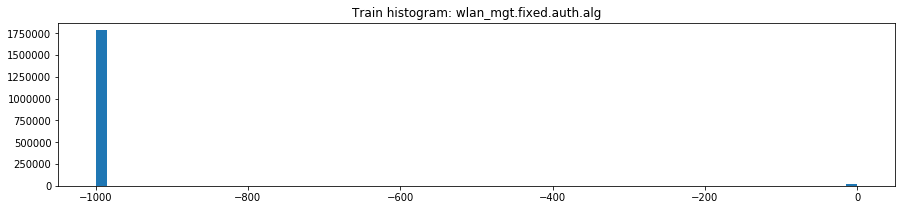

,wlan_mgt.fixed.auth.alg,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.0,567545.000000
1,mean,-9.901754e+02,-991.438062,-9.901404e+02,-998.557459,-999.0,-998.551146
2,std,9.347653e+01,86.587226,9.366027e+01,21.021490,0.0,21.170846
3,min,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.0,-999.000000
4,25%,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.0,-999.000000
5,50%,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.0,-999.000000
6,75%,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.0,-999.000000
7,max,0.000000e+00,0.000000,0.000000e+00,0.000000,-999.0,0.000000
8,unique values,2.000000e+00,2.000000,2.000000e+00,2.000000,1.0,2.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000


,wlan_mgt.fixed.auth.alg,Count in train (desc),Mean target train,Sum target train
0,-999.0,1779713,0.027036,48117
1,0.0,15861,0.023139,367


,wlan_mgt.fixed.auth.alg,Count in test (desc),Mean target test,Sum target test
0,-999.0,575387,0.014072,8097
1,0.0,255,0.000000,0


,Column,Correlation with wlan_mgt.fixed.auth.alg
0,wlan_mgt.fixed.auth.alg,1.000000
1,wlan.duration,0.180693
2,wlan.wep.iv_passed1second_count,0.163941
3,wlan.wep.icv_passed1second_count,0.163941
4,frame.time_relative,0.082290
5,passed1second,0.079123
29,wlan.ta_passed1second_count,-0.037635
30,wlan.da_passed1second_count,-0.054265
31,frame.len,-0.064170
32,radiotap.datarate,-0.096008


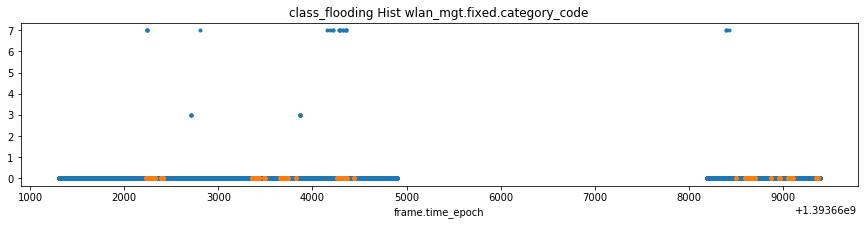

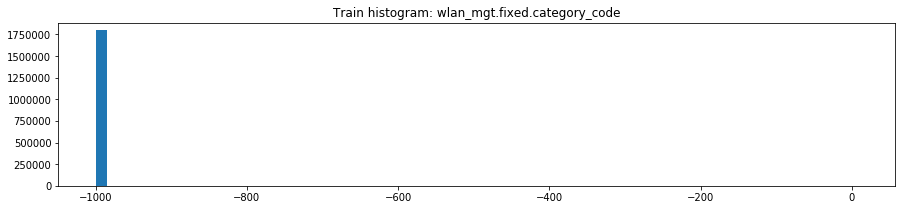

,wlan_mgt.fixed.category_code,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.0,1.747090e+06,575642.000000,8097.0,567545.000000
1,mean,-9.989843e+02,-999.0,-9.989839e+02,-998.994757,-999.0,-998.994682
2,std,3.966941e+00,0.0,4.021607e+00,2.296580,0.0,2.312904
3,min,-9.990000e+02,-999.0,-9.990000e+02,-999.000000,-999.0,-999.000000
4,25%,-9.990000e+02,-999.0,-9.990000e+02,-999.000000,-999.0,-999.000000
5,50%,-9.990000e+02,-999.0,-9.990000e+02,-999.000000,-999.0,-999.000000
6,75%,-9.990000e+02,-999.0,-9.990000e+02,-999.000000,-999.0,-999.000000
7,max,7.000000e+00,-999.0,7.000000e+00,7.000000,-999.0,7.000000
8,unique values,3.000000e+00,1.0,3.000000e+00,2.000000,1.0,2.000000
9,NaNs,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000


,wlan_mgt.fixed.category_code,Count in train (desc),Mean target train,Sum target train
0,-999.0,1795546,0.027002,48484
1,7.0,18,0.000000,0
2,3.0,10,0.000000,0


,wlan_mgt.fixed.category_code,Count in test (desc),Mean target test,Sum target test
0,-999.0,575639,0.014066,8097
1,7.0,3,0.000000,0


,Column,Correlation with wlan_mgt.fixed.category_code
0,wlan_mgt.fixed.category_code,1.000000
1,wlan.duration,0.004658
2,wlan.fc.subtype,0.004259
3,wlan.wep.icv_passed1second_count,0.003251
4,wlan.wep.iv_passed1second_count,0.003251
5,wlan.frag,0.002302
29,wlan.ra_passed1second_count,-0.003720
30,wlan.da_passed1second_count,-0.003874
31,wlan.ta_passed1second_count,-0.003890
32,radiotap.datarate,-0.004016


,wlan_mgt.ssid,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,10,3,10,10,2,10
2,top,Missing,Missing,Missing,Missing,Missing,Missing
3,freq,1628381,42002,1586379,517921,7498,510423
4,unique values,10,3,10,10,2,10
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan_mgt.ssid,Count in train (desc),Mean target train,Sum target train
0,Missing,1628381,0.025794,42002
1,AegeanSecLab,47782,0.065569,3133
2,pnet,41340,0.000000,0
3,OTE29224e,28564,0.000000,0
4,CYTA C565,27158,0.000000,0
5,CYTA 8D28,16348,0.000000,0
6,Rare,5112,0.655125,3349
7,mhxskl140,335,0.000000,0
8,NetFasteR IAD 2 (PSTN),278,0.000000,0
9,OTE CONNX,276,0.000000,0


,wlan_mgt.ssid,Count in test (desc),Mean target test,Sum target test
0,Missing,517921,0.014477,7498
1,AegeanSecLab,14990,0.000000,0
2,OTE29224e,10733,0.000000,0
3,pnet,10431,0.000000,0
4,CYTA C565,9686,0.000000,0
5,CYTA 8D28,6929,0.000000,0
6,Rare,3539,0.169257,599
7,OTE CONNX,920,0.000000,0
8,NetFasteR IAD 2 (PSTN),253,0.000000,0
9,mhxskl140,240,0.000000,0


,wlan_mgt.country_info.environment,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,4,2,4,4,1,4
2,top,Missing,Missing,Missing,Missing,Missing,Missing
3,freq,1790614,48466,1742148,569724,8097,561627
4,unique values,4,2,4,4,1,4
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan_mgt.country_info.environment,Count in train (desc),Mean target train,Sum target train
0,Missing,1790614,0.027067,48466
1,0x49,4564,0.000000,0
2,0x20,346,0.000000,0
3,Rare,50,0.360000,18


,wlan_mgt.country_info.environment,Count in test (desc),Mean target test,Sum target test
0,Missing,569724,0.014212,8097
1,0x49,3835,0.000000,0
2,0x20,2072,0.000000,0
3,Rare,11,0.000000,0


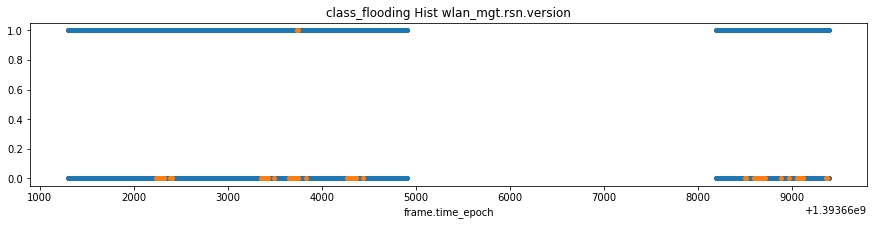

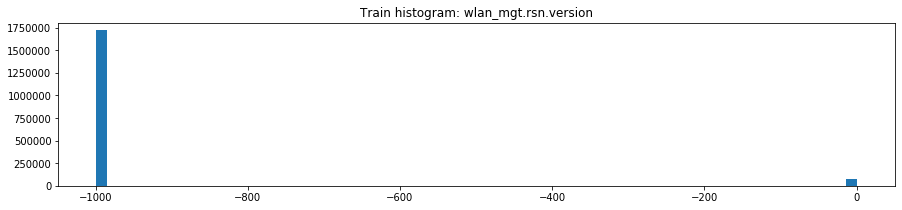

,wlan_mgt.rsn.version,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.0,567545.000000
1,mean,-9.561480e+02,-998.587493,-9.549702e+02,-941.311367,-999.0,-940.488340
2,std,2.025235e+02,20.306294,2.051614e+02,233.153917,0.0,234.708633
3,min,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.0,-999.000000
4,25%,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.0,-999.000000
5,50%,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.0,-999.000000
6,75%,-9.990000e+02,-999.000000,-9.990000e+02,-999.000000,-999.0,-999.000000
7,max,1.000000e+00,1.000000,1.000000e+00,1.000000,-999.0,1.000000
8,unique values,2.000000e+00,2.000000,2.000000e+00,2.000000,1.0,2.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000


,wlan_mgt.rsn.version,Count in train (desc),Mean target train,Sum target train
0,-999.0,1718630,0.028199,48464
1,1.0,76944,0.000260,20


,wlan_mgt.rsn.version,Count in test (desc),Mean target test,Sum target test
0,-999.0,542434,0.014927,8097
1,1.0,33208,0.000000,0


,Column,Correlation with wlan_mgt.rsn.version
0,wlan_mgt.rsn.version,1.000000
1,wlan_mgt.fixed.capabilities.ess,0.632122
2,frame.time_delta,0.425785
3,wlan.frag,0.123340
4,wlan.seq,0.106542
5,class_normal,0.066527
29,radiotap.datarate,-0.215189
30,wlan.da_passed1second_count,-0.243899
31,wlan.ra_passed1second_count,-0.265426
32,wlan.ta_passed1second_count,-0.280105


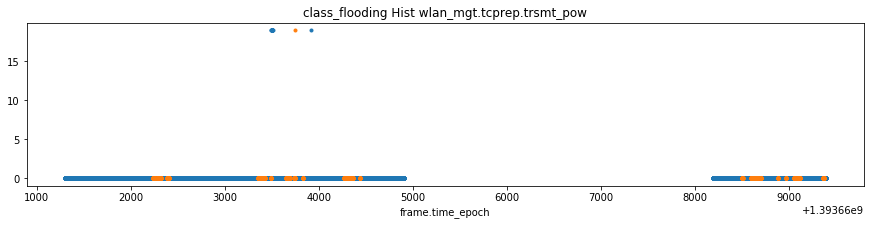

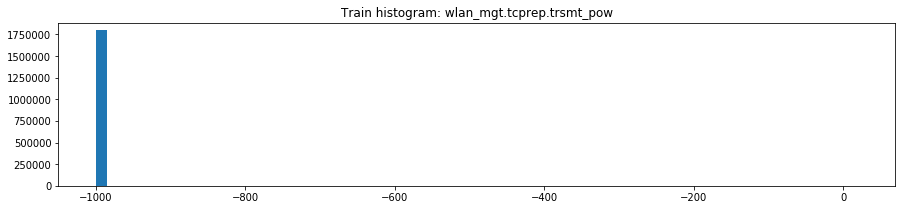

,wlan_mgt.tcprep.trsmt_pow,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.0,8097.0,567545.0
1,mean,-9.989779e+02,-998.979003,-9.989779e+02,-999.0,-999.0,-999.0
2,std,4.744318e+00,4.623263,4.747635e+00,0.0,0.0,0.0
3,min,-9.990000e+02,-999.000000,-9.990000e+02,-999.0,-999.0,-999.0
4,25%,-9.990000e+02,-999.000000,-9.990000e+02,-999.0,-999.0,-999.0
5,50%,-9.990000e+02,-999.000000,-9.990000e+02,-999.0,-999.0,-999.0
6,75%,-9.990000e+02,-999.000000,-9.990000e+02,-999.0,-999.0,-999.0
7,max,1.900000e+01,19.000000,1.900000e+01,-999.0,-999.0,-999.0
8,unique values,2.000000e+00,2.000000,2.000000e+00,1.0,1.0,1.0
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0


,wlan_mgt.tcprep.trsmt_pow,Count in train (desc),Mean target train,Sum target train
0,-999.0,1795535,0.027002,48483
1,19.0,39,0.025641,1


,wlan_mgt.tcprep.trsmt_pow,Count in test (desc),Mean target test,Sum target test
0,-999.0,575642,0.014066,8097


,Column,Correlation with wlan_mgt.tcprep.trsmt_pow
0,wlan_mgt.tcprep.trsmt_pow,1.000000
1,wlan_mgt.rsn.version,0.021436
2,wlan_mgt.fixed.capabilities.ess,0.013930
3,frame.time_delta,0.004798
4,wlan.duration,0.003073
5,wlan.fc.retry,0.002885
29,wlan.da_passed1second_count,-0.003568
30,wlan.ra_passed1second_count,-0.004205
31,radiotap.datarate,-0.004740
32,wlan.ta_passed1second_count,-0.006127


,wlan.tkip.extiv,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,2,1,2,2,1,2
2,top,Missing,Missing,Missing,Missing,Missing,Missing
3,freq,1763654,48484,1715170,561404,8097,553307
4,unique values,2,1,2,2,1,2
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan.tkip.extiv,Count in train (desc),Mean target train,Sum target train
0,Missing,1763654,0.027491,48484
1,Rare,31920,0.000000,0


,wlan.tkip.extiv,Count in test (desc),Mean target test,Sum target test
0,Missing,561404,0.014423,8097
1,Rare,14238,0.000000,0


,wlan.ccmp.extiv,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1795574,48484,1747090,575642,8097,567545
1,unique,2,1,2,2,1,2
2,top,Missing,Missing,Missing,Missing,Missing,Missing
3,freq,1792505,48484,1744021,522207,8097,514110
4,unique values,2,1,2,2,1,2
5,NaNs,0,0,0,0,0,0
6,NaNs share,0,0,0,0,0,0


,wlan.ccmp.extiv,Count in train (desc),Mean target train,Sum target train
0,Missing,1792505,0.027048,48484
1,Rare,3069,0.000000,0


,wlan.ccmp.extiv,Count in test (desc),Mean target test,Sum target test
0,Missing,522207,0.015505,8097
1,Rare,53435,0.000000,0


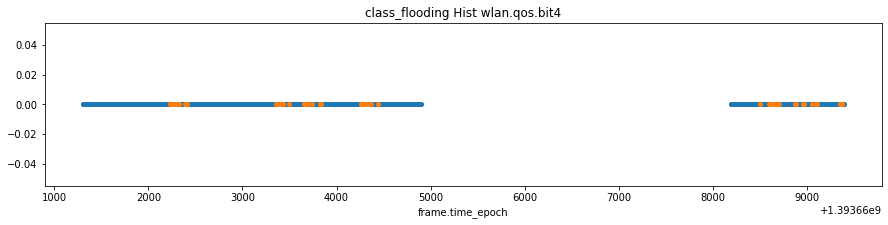

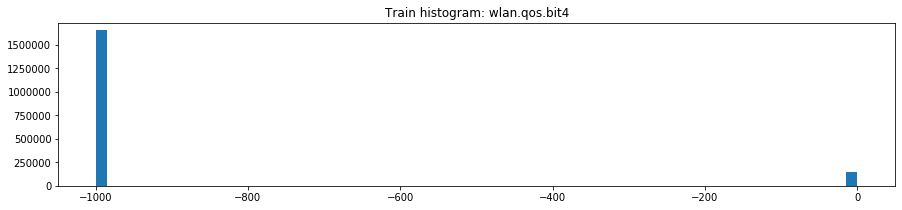

,wlan.qos.bit4,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.0,1.747090e+06,575642.000000,8097.0,567545.000000
1,mean,-9.174142e+02,-999.0,-9.151501e+02,-928.583969,-999.0,-927.579364
2,std,2.735837e+02,0.0,2.770114e+02,255.709427,0.0,257.387694
3,min,-9.990000e+02,-999.0,-9.990000e+02,-999.000000,-999.0,-999.000000
4,25%,-9.990000e+02,-999.0,-9.990000e+02,-999.000000,-999.0,-999.000000
5,50%,-9.990000e+02,-999.0,-9.990000e+02,-999.000000,-999.0,-999.000000
6,75%,-9.990000e+02,-999.0,-9.990000e+02,-999.000000,-999.0,-999.000000
7,max,0.000000e+00,-999.0,0.000000e+00,0.000000,-999.0,0.000000
8,unique values,2.000000e+00,1.0,2.000000e+00,2.000000,1.0,2.000000
9,NaNs,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000


,wlan.qos.bit4,Count in train (desc),Mean target train,Sum target train
0,-999.0,1648934,0.029403,48484
1,0.0,146640,0.000000,0


,wlan.qos.bit4,Count in test (desc),Mean target test,Sum target test
0,-999.0,535067,0.015133,8097
1,0.0,40575,0.000000,0


,Column,Correlation with wlan.qos.bit4
0,wlan.qos.bit4,1.000000
1,radiotap.datarate,0.309145
2,wlan.fc.type,0.264604
3,wlan.frag,0.173834
4,wlan.seq,0.146660
5,class_normal,0.094033
29,frame.len,-0.170114
30,wlan.da_passed1second_count,-0.183124
31,wlan.ta_passed1second_count,-0.188848
32,wlan.wep.icv_passed1second_count,-0.236928


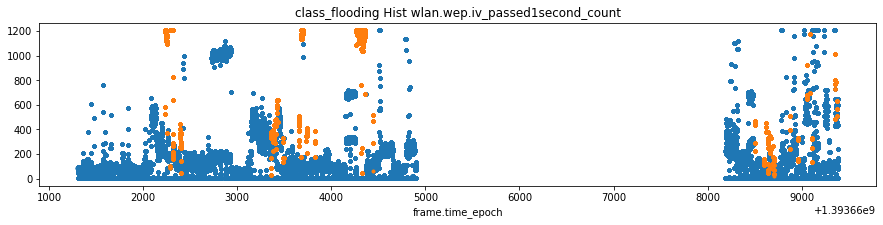

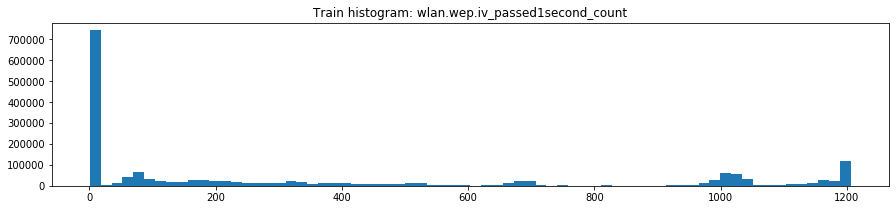

,wlan.wep.iv_passed1second_count,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,3.576156e+02,954.667767,3.410467e+02,380.791836,480.472891,379.369715
2,std,4.453777e+02,362.644026,4.359466e+02,424.709890,319.050759,425.859180
3,min,1.000000e+00,26.000000,1.000000e+00,1.000000,20.000000,1.000000
4,25%,1.000000e+00,518.000000,1.000000e+00,1.000000,285.000000,1.000000
5,50%,1.020000e+02,1164.000000,9.000000e+01,219.000000,344.000000,209.000000
6,75%,6.910000e+02,1201.000000,6.790000e+02,656.000000,645.000000,656.000000
7,max,1.206000e+03,1206.000000,1.206000e+03,1206.000000,1172.000000,1206.000000
8,unique values,7.210000e+02,163.000000,7.210000e+02,501.000000,68.000000,501.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.wep.iv_passed1second_count,Count in train (desc),Mean target train,Sum target train
0,1.0,684492,0.000000,0
1,1206.0,90197,0.106301,9588
2,2.0,42216,0.000000,0
3,3.0,8514,0.000000,0
4,1007.0,8056,0.000000,0
5,1006.0,8048,0.000000,0
6,1014.0,6084,0.000000,0
7,1170.0,5850,0.209744,1227
8,85.0,5525,0.000000,0
9,68.0,5236,0.000000,0


,wlan.wep.iv_passed1second_count,Count in test (desc),Mean target test,Sum target test
0,1.0,179868,0.0,0
1,1206.0,74484,0.0,0
2,2.0,16174,0.0,0
3,3.0,4650,0.0,0
4,726.0,2178,0.0,0
5,4.0,2104,0.0,0
6,677.0,2031,0.0,0
7,661.0,1983,0.0,0
8,913.0,1826,0.0,0
9,588.0,1764,0.0,0


,Column,Correlation with wlan.wep.iv_passed1second_count
0,wlan.wep.iv_passed1second_count,1.000000
1,wlan.wep.icv_passed1second_count,1.000000
2,wlan.duration,0.466967
3,wlan.fc.subtype,0.371164
4,wlan.fc.retry,0.313394
5,class_flooding,0.223319
29,wlan.seq,-0.241303
30,wlan.frag,-0.316018
31,frame.len,-0.537762
32,wlan.fc.type,-0.664378


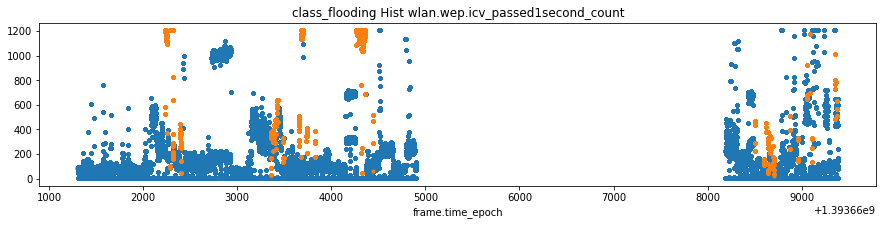

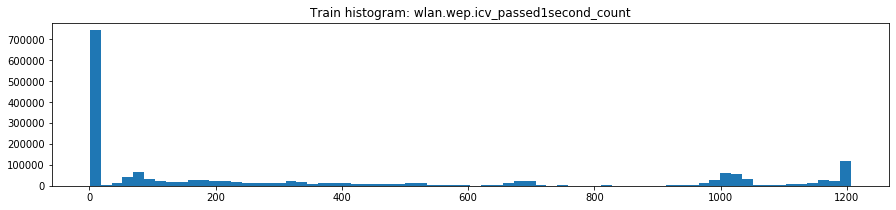

,wlan.wep.icv_passed1second_count,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,3.576142e+02,954.667767,3.410452e+02,377.060826,480.472891,375.585476
2,std,4.453788e+02,362.644026,4.359477e+02,426.303019,319.050759,427.457826
3,min,1.000000e+00,26.000000,1.000000e+00,1.000000,20.000000,1.000000
4,25%,1.000000e+00,518.000000,1.000000e+00,1.000000,285.000000,1.000000
5,50%,1.020000e+02,1164.000000,9.000000e+01,200.000000,344.000000,191.000000
6,75%,6.910000e+02,1201.000000,6.790000e+02,656.000000,645.000000,656.000000
7,max,1.206000e+03,1206.000000,1.206000e+03,1206.000000,1172.000000,1206.000000
8,unique values,7.210000e+02,163.000000,7.210000e+02,499.000000,68.000000,499.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.wep.icv_passed1second_count,Count in train (desc),Mean target train,Sum target train
0,1.0,684671,0.000000,0
1,1206.0,90197,0.106301,9588
2,2.0,42228,0.000000,0
3,3.0,8511,0.000000,0
4,1007.0,8056,0.000000,0
5,1006.0,8048,0.000000,0
6,1014.0,6084,0.000000,0
7,1170.0,5850,0.209744,1227
8,85.0,5525,0.000000,0
9,68.0,5236,0.000000,0


,wlan.wep.icv_passed1second_count,Count in test (desc),Mean target test,Sum target test
0,1.0,184893,0.0,0
1,1206.0,74484,0.0,0
2,2.0,16180,0.0,0
3,3.0,4656,0.0,0
4,726.0,2178,0.0,0
5,4.0,2108,0.0,0
6,677.0,2031,0.0,0
7,661.0,1983,0.0,0
8,913.0,1826,0.0,0
9,441.0,1764,0.0,0


,Column,Correlation with wlan.wep.icv_passed1second_count
0,wlan.wep.icv_passed1second_count,1.000000
1,wlan.wep.iv_passed1second_count,1.000000
2,wlan.duration,0.466961
3,wlan.fc.subtype,0.371169
4,wlan.fc.retry,0.313395
5,class_flooding,0.223319
29,wlan.seq,-0.241304
30,wlan.frag,-0.316019
31,frame.len,-0.537759
32,wlan.fc.type,-0.664379


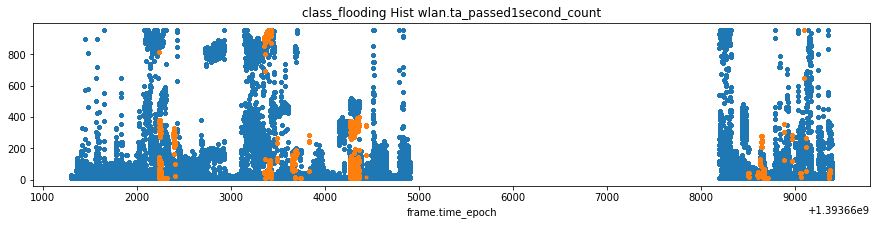

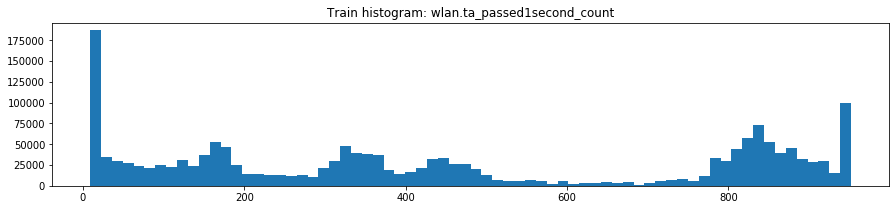

,wlan.ta_passed1second_count,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,4.511979e+02,205.723558,4.580101e+02,406.101362,307.768186,407.504253
2,std,3.310500e+02,157.643301,3.320048e+02,331.735975,304.782912,331.894206
3,min,9.000000e+00,9.000000,9.000000e+00,9.000000,9.000000,9.000000
4,25%,1.530000e+02,112.000000,1.570000e+02,110.000000,86.000000,111.000000
5,50%,3.760000e+02,143.000000,3.980000e+02,305.000000,244.000000,308.000000
6,75%,8.240000e+02,330.000000,8.260000e+02,744.000000,307.000000,753.000000
7,max,9.520000e+02,952.000000,9.520000e+02,952.000000,952.000000,952.000000
8,unique values,7.700000e+02,243.000000,7.700000e+02,570.000000,69.000000,570.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.ta_passed1second_count,Count in train (desc),Mean target train,Sum target train
0,9.0,102723,0.035786,3676
1,952.0,89799,0.001025,92
2,10.0,19560,0.004601,90
3,11.0,9757,0.005637,55
4,832.0,9152,0.000000,0
5,825.0,8250,0.000000,0
6,12.0,7704,0.009865,76
7,843.0,7587,0.000000,0
8,819.0,7371,0.000000,0
9,873.0,6984,0.011312,79


,wlan.ta_passed1second_count,Count in test (desc),Mean target test,Sum target test
0,952.0,54990,0.020204,1111
1,9.0,37704,0.018698,705
2,10.0,7490,0.000935,7
3,11.0,4532,0.003530,16
4,12.0,3288,0.002433,8
5,13.0,2964,0.004386,13
6,936.0,2808,0.000000,0
7,14.0,2632,0.000000,0
8,860.0,2580,0.000000,0
9,857.0,2571,0.000000,0


,Column,Correlation with wlan.ta_passed1second_count
0,wlan.ta_passed1second_count,1.000000
1,wlan.da_passed1second_count,0.845218
2,wlan.ra_passed1second_count,0.811966
3,frame.len,0.449671
4,wlan.fc.retry,0.271912
5,radiotap.datarate,0.263270
29,wlan.qos.bit4,-0.188848
30,frame.time_relative,-0.191946
31,wlan_mgt.rsn.version,-0.280105
32,frame.time_delta,-0.318203


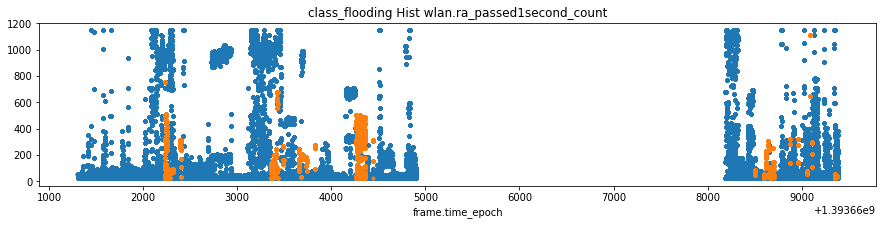

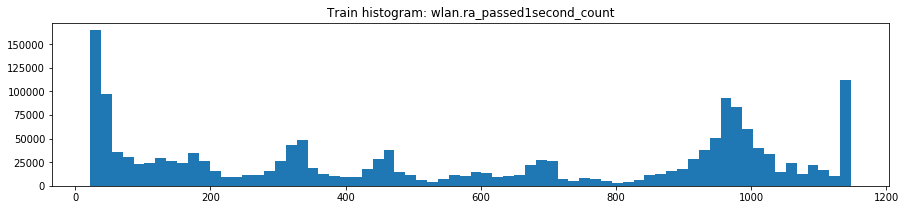

,wlan.ra_passed1second_count,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,5.685395e+02,287.710193,5.763329e+02,463.736875,359.441769,465.224823
2,std,3.995222e+02,132.168106,4.016385e+02,377.518924,334.735560,377.886332
3,min,2.200000e+01,22.000000,2.200000e+01,22.000000,22.000000,22.000000
4,25%,1.630000e+02,184.000000,1.610000e+02,124.000000,145.000000,124.000000
5,50%,5.570000e+02,298.000000,5.910000e+02,353.000000,268.000000,353.000000
6,75%,9.690000e+02,393.000000,9.710000e+02,774.000000,320.000000,775.000000
7,max,1.148000e+03,757.000000,1.148000e+03,1148.000000,1111.000000,1148.000000
8,unique values,8.770000e+02,295.000000,8.770000e+02,594.000000,77.000000,593.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.ra_passed1second_count,Count in train (desc),Mean target train,Sum target train
0,1148.0,92746,0.000000,0
1,22.0,91373,0.008799,804
2,965.0,10615,0.000000,0
3,984.0,8856,0.000000,0
4,976.0,8784,0.000000,0
5,959.0,8631,0.000000,0
6,45.0,8550,0.005965,51
7,44.0,8316,0.012145,101
8,43.0,8213,0.001096,9
9,1001.0,8008,0.000000,0


,wlan.ra_passed1second_count,Count in test (desc),Mean target test,Sum target test
0,22.0,29208,0.004862,142
1,1148.0,28660,0.000000,0
2,57.0,3192,0.000940,3
3,633.0,3165,0.000000,0
4,1046.0,3138,0.000000,0
5,1038.0,3114,0.000000,0
6,49.0,3087,0.008422,26
7,54.0,2916,0.014060,41
8,364.0,2912,0.000000,0
9,47.0,2820,0.018085,51


,Column,Correlation with wlan.ra_passed1second_count
0,wlan.ra_passed1second_count,1.000000
1,wlan.ta_passed1second_count,0.811966
2,wlan.da_passed1second_count,0.801455
3,frame.len,0.337000
4,radiotap.datarate,0.243904
5,wlan.fc.retry,0.217202
29,passed1second,-0.178365
30,frame.time_relative,-0.192724
31,wlan_mgt.rsn.version,-0.265426
32,frame.time_delta,-0.360993


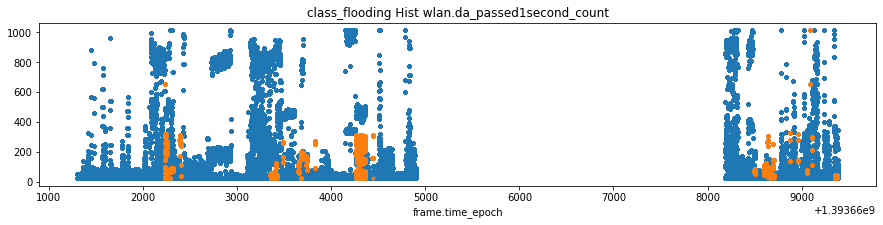

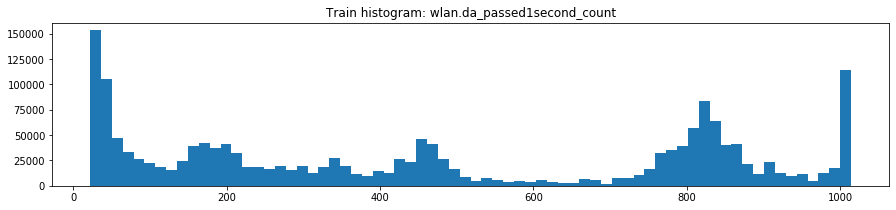

,wlan.da_passed1second_count,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,4.697167e+02,201.676512,4.771551e+02,432.310492,338.312461,433.651534
2,std,3.432198e+02,82.757195,3.447169e+02,348.068923,310.315669,348.394758
3,min,2.200000e+01,22.000000,2.200000e+01,22.000000,22.000000,22.000000
4,25%,1.510000e+02,164.000000,1.510000e+02,103.000000,107.000000,103.000000
5,50%,4.320000e+02,211.000000,4.480000e+02,324.000000,268.000000,330.000000
6,75%,8.190000e+02,269.000000,8.210000e+02,830.000000,320.000000,831.000000
7,max,1.014000e+03,651.000000,1.014000e+03,1014.000000,1014.000000,1014.000000
8,unique values,7.980000e+02,234.000000,7.980000e+02,580.000000,67.000000,580.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.da_passed1second_count,Count in train (desc),Mean target train,Sum target train
0,22.0,91134,0.017260,1573
1,1014.0,90369,0.000000,0
2,809.0,9708,0.000000,0
3,825.0,9075,0.000000,0
4,42.0,8820,0.004762,42
5,45.0,8460,0.004965,42
6,43.0,8299,0.025907,215
7,827.0,8270,0.000000,0
8,40.0,8240,0.005583,46
9,818.0,8180,0.000000,0


,wlan.da_passed1second_count,Count in test (desc),Mean target test,Sum target test
0,22.0,31689,0.008457,268
1,1014.0,20739,0.053571,1111
2,936.0,3744,0.000000,0
3,930.0,3720,0.000000,0
4,917.0,3668,0.000000,0
5,49.0,3528,0.005102,18
6,860.0,3440,0.000000,0
7,847.0,3388,0.000000,0
8,47.0,3384,0.011820,40
9,48.0,2880,0.003819,11


,Column,Correlation with wlan.da_passed1second_count
0,wlan.da_passed1second_count,1.000000
1,wlan.ta_passed1second_count,0.845218
2,wlan.ra_passed1second_count,0.801455
3,frame.len,0.292656
4,wlan.duration,0.249191
5,wlan.fc.retry,0.210908
29,class_flooding,-0.130098
30,wlan.qos.bit4,-0.183124
31,wlan_mgt.rsn.version,-0.243899
32,frame.time_delta,-0.308531


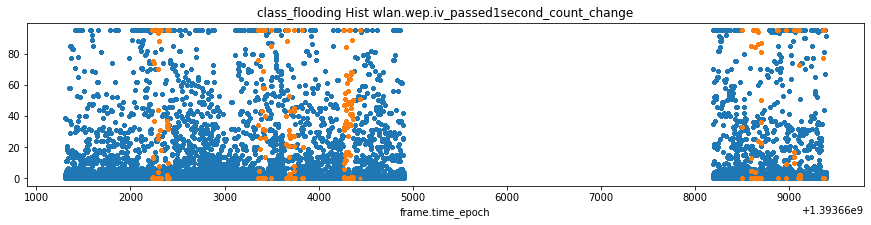

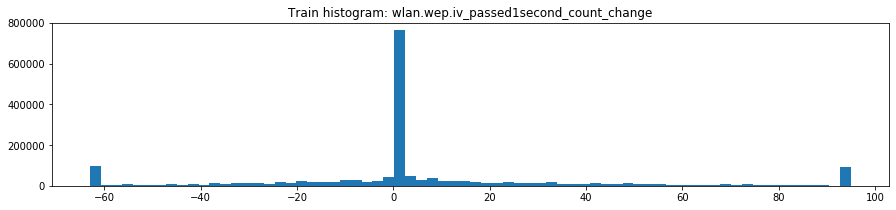

,wlan.wep.iv_passed1second_count_change,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,5.153764e+00,11.209017,4.985723e+00,11.103688,30.129801,10.832248
2,std,3.383262e+01,50.141832,3.325049e+01,49.212530,65.109920,48.894925
3,min,-6.300000e+01,-63.000000,-6.300000e+01,-63.000000,-63.000000,-63.000000
4,25%,-1.000000e+00,-30.000000,-1.000000e+00,-8.000000,-40.000000,-8.000000
5,50%,1.000000e+00,6.000000,1.000000e+00,1.000000,36.000000,1.000000
6,75%,9.000000e+00,45.000000,8.000000e+00,35.000000,95.000000,33.000000
7,max,9.500000e+01,95.000000,9.500000e+01,95.000000,95.000000,95.000000
8,unique values,1.580000e+02,107.000000,1.580000e+02,154.000000,36.000000,154.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.wep.iv_passed1second_count_change,Count in train (desc),Mean target train,Sum target train
0,1.0,702218,0.001999,1404
1,-63.0,91689,0.066377,6086
2,95.0,89947,0.065683,5908
3,2.0,60132,0.007168,431
4,3.0,26883,0.012833,345
5,4.0,19485,0.002412,47
6,5.0,16267,0.014446,235
7,14.0,15793,0.034889,551
8,-8.0,15598,0.023529,367
9,12.0,15499,0.016840,261


,wlan.wep.iv_passed1second_count_change,Count in test (desc),Mean target test,Sum target test
0,1.0,183426,0.000000,0
1,95.0,97950,0.030240,2962
2,-63.0,77364,0.022090,1709
3,2.0,19333,0.012311,238
4,3.0,6607,0.000000,0
5,4.0,4999,0.042208,211
6,-14.0,4140,0.009903,41
7,22.0,4130,0.000000,0
8,-10.0,4085,0.000000,0
9,-2.0,3685,0.049118,181


,Column,Correlation with wlan.wep.iv_passed1second_count_change
0,wlan.wep.iv_passed1second_count_change,1.000000
1,wlan.wep.icv_passed1second_count_change,0.999990
2,wlan.ta_passed1second_count_change,0.512401
3,wlan.da_passed1second_count_change,0.506716
4,wlan.ra_passed1second_count_change,0.394928
5,wlan.wep.iv_passed1second_count,0.114515
29,radiotap.datarate,-0.059015
30,wlan.fc.type,-0.062402
31,frame.len,-0.081247
32,wlan.seq,-0.101378


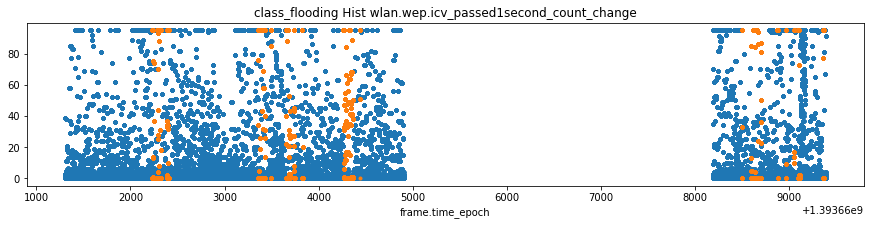

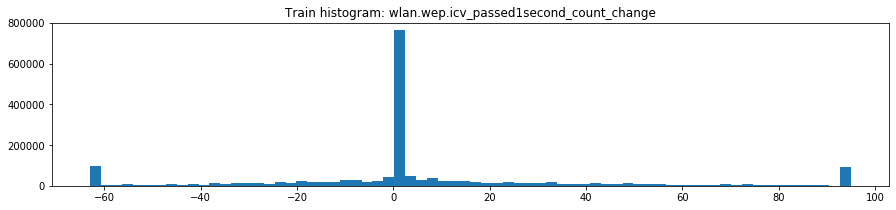

,wlan.wep.icv_passed1second_count_change,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,5.152899e+00,11.209017,4.984834e+00,10.861160,30.129801,10.586260
2,std,3.383266e+01,50.141832,3.325053e+01,48.749042,65.109920,48.420321
3,min,-6.300000e+01,-63.000000,-6.300000e+01,-63.000000,-63.000000,-63.000000
4,25%,-1.000000e+00,-30.000000,-1.000000e+00,-7.000000,-40.000000,-7.000000
5,50%,1.000000e+00,6.000000,1.000000e+00,1.000000,36.000000,1.000000
6,75%,9.000000e+00,45.000000,8.000000e+00,33.000000,95.000000,32.000000
7,max,9.500000e+01,95.000000,9.500000e+01,95.000000,95.000000,95.000000
8,unique values,1.580000e+02,107.000000,1.580000e+02,158.000000,36.000000,158.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.wep.icv_passed1second_count_change,Count in train (desc),Mean target train,Sum target train
0,1.0,702385,0.001999,1404
1,-63.0,91689,0.066377,6086
2,95.0,89946,0.065684,5908
3,2.0,60109,0.007170,431
4,3.0,26883,0.012833,345
5,4.0,19485,0.002412,47
6,5.0,16262,0.014451,235
7,14.0,15793,0.034889,551
8,-8.0,15598,0.023529,367
9,12.0,15428,0.016917,261


,wlan.wep.icv_passed1second_count_change,Count in test (desc),Mean target test,Sum target test
0,1.0,188095,0.000000,0
1,95.0,93039,0.031836,2962
2,-63.0,76233,0.022418,1709
3,2.0,19376,0.012283,238
4,3.0,6401,0.000000,0
5,4.0,4796,0.043995,211
6,22.0,4152,0.000000,0
7,-14.0,4140,0.009903,41
8,-10.0,4085,0.000000,0
9,-3.0,3426,0.054291,186


,Column,Correlation with wlan.wep.icv_passed1second_count_change
0,wlan.wep.icv_passed1second_count_change,1.000000
1,wlan.wep.iv_passed1second_count_change,0.999990
2,wlan.ta_passed1second_count_change,0.512395
3,wlan.da_passed1second_count_change,0.506708
4,wlan.ra_passed1second_count_change,0.394926
5,wlan.wep.iv_passed1second_count,0.114535
29,radiotap.datarate,-0.058993
30,wlan.fc.type,-0.062425
31,frame.len,-0.081232
32,wlan.seq,-0.101397


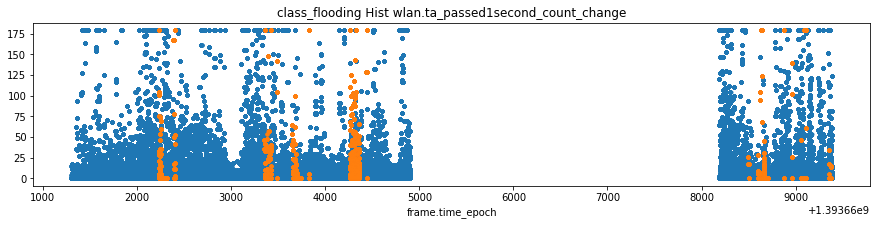

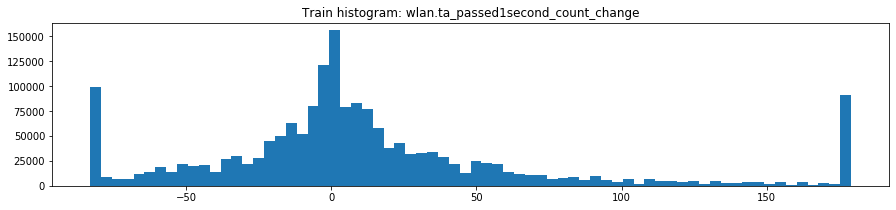

,wlan.ta_passed1second_count_change,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,1.281430e+01,10.459224,1.287965e+01,20.722432,44.947511,20.376819
2,std,5.896286e+01,44.562982,5.931131e+01,72.312583,89.565809,71.977677
3,min,-8.300000e+01,-83.000000,-8.300000e+01,-83.000000,-83.000000,-83.000000
4,25%,-1.600000e+01,-10.000000,-1.700000e+01,-22.000000,-7.000000,-22.000000
5,50%,3.000000e+00,2.000000,3.000000e+00,4.000000,7.000000,4.000000
6,75%,3.000000e+01,19.000000,3.100000e+01,53.000000,139.000000,53.000000
7,max,1.790000e+02,179.000000,1.790000e+02,179.000000,179.000000,179.000000
8,unique values,2.550000e+02,150.000000,2.550000e+02,243.000000,59.000000,243.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.ta_passed1second_count_change,Count in train (desc),Mean target train,Sum target train
0,-83.0,91460,0.010256,938
1,179.0,89868,0.012841,1154
2,1.0,45143,0.093924,4240
3,0.0,41416,0.020668,856
4,-1.0,38416,0.017128,658
5,2.0,37982,0.017140,651
6,-3.0,31862,0.017356,553
7,3.0,31445,0.034059,1071
8,6.0,28972,0.029615,858
9,-2.0,27391,0.031835,872


,wlan.ta_passed1second_count_change,Count in test (desc),Mean target test,Sum target test
0,-83.0,55414,0.016945,939
1,179.0,48214,0.039221,1891
2,2.0,12642,0.004351,55
3,1.0,12537,0.056951,714
4,0.0,11850,0.010717,127
5,-2.0,11014,0.013074,144
6,-1.0,10945,0.000365,4
7,5.0,9306,0.005158,48
8,3.0,8608,0.002788,24
9,4.0,8231,0.001701,14


,Column,Correlation with wlan.ta_passed1second_count_change
0,wlan.ta_passed1second_count_change,1.000000
1,wlan.da_passed1second_count_change,0.914002
2,wlan.ra_passed1second_count_change,0.792988
3,wlan.wep.iv_passed1second_count_change,0.512401
4,wlan.wep.icv_passed1second_count_change,0.512395
5,wlan.ta_passed1second_count,0.121633
29,wlan.frag,-0.039589
30,wlan.seq,-0.041083
31,wlan_mgt.rsn.version,-0.043212
32,wlan_mgt.fixed.capabilities.ess,-0.056704


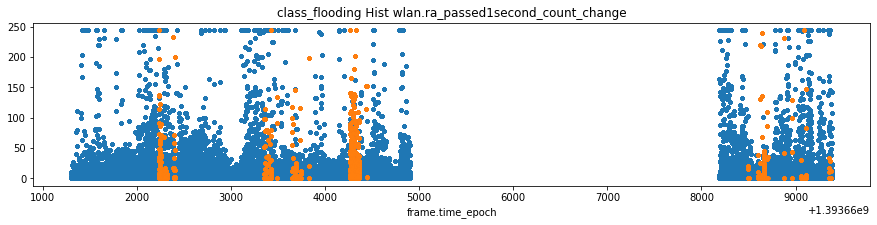

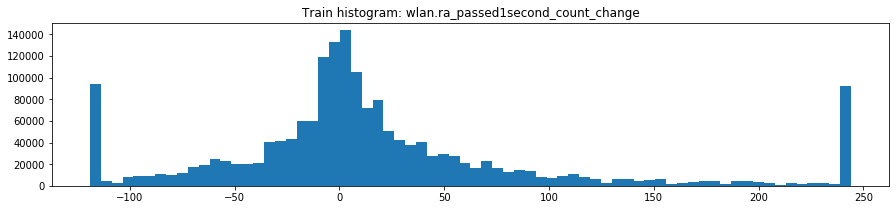

,wlan.ra_passed1second_count_change,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.000000,567545.000000
1,mean,1.759851e+01,14.330398,1.768920e+01,29.100658,62.222181,28.628123
2,std,7.950343e+01,60.147597,7.997191e+01,97.888069,116.290612,97.519188
3,min,-1.190000e+02,-119.000000,-1.190000e+02,-119.000000,-119.000000,-119.000000
4,25%,-1.900000e+01,-15.000000,-1.900000e+01,-24.000000,-9.000000,-24.000000
5,50%,4.000000e+00,4.000000,4.000000e+00,7.000000,35.000000,6.000000
6,75%,3.800000e+01,30.000000,3.800000e+01,68.000000,135.000000,67.000000
7,max,2.440000e+02,244.000000,2.440000e+02,244.000000,244.000000,244.000000
8,unique values,3.300000e+02,195.000000,3.300000e+02,312.000000,81.000000,312.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000


,wlan.ra_passed1second_count_change,Count in train (desc),Mean target train,Sum target train
0,-119.0,91250,0.009052,826
1,244.0,90180,0.006775,611
2,1.0,37210,0.015722,585
3,0.0,31189,0.030524,952
4,-1.0,28956,0.043860,1270
5,3.0,28724,0.014866,427
6,-2.0,28216,0.020875,589
7,2.0,27750,0.035892,996
8,4.0,27619,0.029328,810
9,8.0,26373,0.006446,170


,wlan.ra_passed1second_count_change,Count in test (desc),Mean target test,Sum target test
0,244.0,50702,0.021912,1111
1,-119.0,49772,0.019951,993
2,1.0,11368,0.012227,139
3,-4.0,9113,0.000219,2
4,-1.0,8905,0.004941,44
5,2.0,8571,0.011667,100
6,5.0,7792,0.001027,8
7,6.0,6602,0.071191,470
8,3.0,6550,0.001985,13
9,4.0,6490,0.015871,103


,Column,Correlation with wlan.ra_passed1second_count_change
0,wlan.ra_passed1second_count_change,1.000000
1,wlan.da_passed1second_count_change,0.861241
2,wlan.ta_passed1second_count_change,0.792988
3,wlan.wep.iv_passed1second_count_change,0.394928
4,wlan.wep.icv_passed1second_count_change,0.394926
5,wlan.ra_passed1second_count,0.135469
29,wlan.seq,-0.034615
30,wlan_mgt.rsn.version,-0.041045
31,wlan.duration,-0.043427
32,wlan_mgt.fixed.capabilities.ess,-0.056583


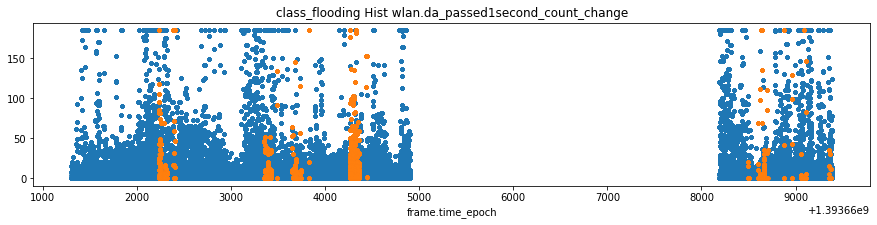

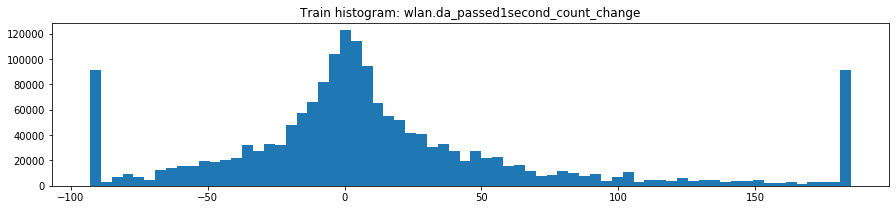

,wlan.da_passed1second_count_change,Train,Train flooding,Train not flooding,Test,Test flooding,Test not flooding
0,count,1.795574e+06,48484.000000,1.747090e+06,575642.000000,8097.00000,567545.000000
1,mean,1.377304e+01,11.135282,1.384624e+01,23.147639,52.53069,22.728439
2,std,6.203651e+01,45.613045,6.242912e+01,78.322330,91.80224,78.033273
3,min,-9.300000e+01,-93.000000,-9.300000e+01,-93.000000,-93.00000,-93.000000
4,25%,-1.700000e+01,-11.000000,-1.700000e+01,-23.000000,-6.00000,-23.000000
5,50%,4.000000e+00,4.000000,4.000000e+00,6.000000,34.00000,6.000000
6,75%,3.200000e+01,20.000000,3.300000e+01,65.000000,135.00000,65.000000
7,max,1.850000e+02,185.000000,1.850000e+02,185.000000,185.00000,185.000000
8,unique values,2.710000e+02,149.000000,2.710000e+02,252.000000,64.00000,252.000000
9,NaNs,0.000000e+00,0.000000,0.000000e+00,0.000000,0.00000,0.000000


,wlan.da_passed1second_count_change,Count in train (desc),Mean target train,Sum target train
0,-93.0,90366,0.007580,685
1,185.0,90043,0.011084,998
2,2.0,34417,0.039428,1357
3,4.0,31329,0.047049,1474
4,1.0,31073,0.028868,897
5,5.0,29463,0.017581,518
6,-1.0,28835,0.023444,676
7,0.0,28257,0.038928,1100
8,-2.0,28174,0.014836,418
9,-3.0,27752,0.034268,951


,wlan.da_passed1second_count_change,Count in test (desc),Mean target test,Sum target test
0,-93.0,54726,0.018437,1009
1,185.0,53389,0.032610,1741
2,1.0,11190,0.008758,98
3,3.0,11086,0.001173,13
4,-1.0,8838,0.005884,52
5,4.0,7587,0.021089,160
6,-4.0,7041,0.012356,87
7,6.0,7021,0.071072,499
8,0.0,6981,0.009311,65
9,-2.0,6590,0.015478,102


,Column,Correlation with wlan.da_passed1second_count_change
0,wlan.da_passed1second_count_change,1.000000
1,wlan.ta_passed1second_count_change,0.914002
2,wlan.ra_passed1second_count_change,0.861241
3,wlan.wep.iv_passed1second_count_change,0.506716
4,wlan.wep.icv_passed1second_count_change,0.506708
5,wlan.ta_passed1second_count,0.124332
29,wlan.seq,-0.029587
30,wlan.duration,-0.032689
31,wlan_mgt.rsn.version,-0.039635
32,wlan_mgt.fixed.capabilities.ess,-0.055648


In [25]:
for col in columns:
    proc(df=train, tcol='frame.time_epoch', target='class_flooding', col=col, target_first=False, df_test=test, include_test=True)